## XGBoost ML-Model. 

###### A. part of Notebook is regional learning with the French/GLACIOCLIM dataset. B. part is transfer learning with Swiss/GLAMOS train set and French/GLACIOCLIM test set

### Setting Up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import numpy as np

from scripts.helpers import *
from scripts.glacioclim_preprocess import *
from scripts.plots import *
from scripts.config_FR import *
from scripts.xgb_helpers import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.FranceConfig()

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'
color_orange = '#FFA500'

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

#### A.1. Read in stake data from preprocess, transform to monthly and add ERA5Land data

###### Load csv into df

In [3]:
data_glacioclim = pd.read_csv(path_PMB_GLACIOCLIM_csv + 'FR_wgms_dataset_all_oggm.csv')

print('Number of glaciers:', len(data_glacioclim['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_glacioclim[data_glacioclim.PERIOD == 'annual']) + len(data_glacioclim[data_glacioclim.PERIOD == 'winter']) + len(data_glacioclim[data_glacioclim.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'summer']))

data_glacioclim.columns


Number of glaciers: 8
Number of winter, summer and annual samples: 10497
Number of annual samples: 4519
Number of winter samples: 3281
Number of summer samples: 2697


Index(['POINT_ID', 'POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE',
       'TO_DATE', 'POINT_BALANCE', 'GLACIER', 'PERIOD', 'GLACIER_ZONE', 'YEAR',
       'DATA_MODIFICATION', 'RGIId', 'aspect', 'slope', 'topo',
       'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v'],
      dtype='object')

In [8]:
display(data_glacioclim[data_glacioclim.isna().any(axis=1)])
data_glacioclim = data_glacioclim.drop(columns=['DATA_MODIFICATION'])
display(data_glacioclim[data_glacioclim.isna().any(axis=1)])

POINT_ID  POINT_LAT  \
0      Argentiere_Tour_Noir_annual_smb_abl_2006_Tour ...  45.944607   
1      Argentiere_Tour_Noir_annual_smb_abl_2006_Tour ...  45.943724   
2      Argentiere_Tour_Noir_annual_smb_abl_2006_Tour ...  45.943192   
3      Argentiere_Tour_Noir_annual_smb_abl_2006_Tour ...  45.942539   
4       Argentiere_annual_smb_accu_2006_acum_setup2006_3  45.951748   
...                                                  ...        ...   
10492     stso_annual_smb_abl_1975_ablation_setup1972_64  45.164382   
10493     stso_annual_smb_abl_1975_ablation_setup1972_65  45.163570   
10494     stso_annual_smb_abl_1975_ablation_setup1972_66  45.162947   
10495     stso_annual_smb_abl_1975_ablation_setup1972_95  45.160835   
10496     stso_annual_smb_abl_1975_ablation_setup1972_96  45.160237   

       POINT_LON  POINT_ELEVATION  FROM_DATE   TO_DATE  POINT_BALANCE  \
0       7.024819          3033.52   20050930  20061004          -0.67   
1       7.022022          2941.68   20050930  20061004          -0.61   
2       7.019273          2862.05   20050930  20061004          -2.94   
3       7.017118          2813.54   20050930  20061004          -2.74   
4       7.022691          3250.00   20050930  20060905           0.37   
...          ...              ...        ...       ...            ...   
10492   6.161886          2803.60   19740921  19751016          -0.13   
10493   6.163471          2811.78   19740921  19751016          -0.64   
10494   6.165220          2802.33   19740921  19751016          -0.38   
10495   6.161273          2860.89   19740921  19751016          -0.02   
10496   6.163014          2860.56   19740921  19751016           0.12   

                                   GLACIER  PERIOD GLACIER_ZONE  YEAR  \
0                 FR4N01235A08 dArgentiere  annual    Tour Noir  2006   
1                 FR4N01235A08 dArgentiere  annual    Tour Noir  2006   
2                 FR4N01235A08 dArgentiere  annual    Tour Noir  2006   
3                 FR4N01235A08 dArgentiere  annual    Tour Noir  2006   
4                 FR4N01235A08 dArgentiere  annual         acum  2006   
...                                    ...     ...          ...   ...   
10492  FR4N01162B09+154D03 de Saint Sorlin  annual     ablation  1975   
10493  FR4N01162B09+154D03 de Saint Sorlin  annual     ablation  1975   
10494  FR4N01162B09+154D03 de Saint Sorlin  annual     ablation  1975   
10495  FR4N01162B09+154D03 de Saint Sorlin  annual     ablation  1975   
10496  FR4N01162B09+154D03 de Saint Sorlin  annual     ablation  1975   

      DATA_MODIFICATION           RGIId      aspect      slope    topo  \
0                   NaN  RGI60-11.03638  253.839254  22.267489  3025.0   
1                   NaN  RGI60-11.03638  246.198458  21.827929  2944.0   
2                   NaN  RGI60-11.03638  250.211112  14.903007  2857.0   
3                   NaN  RGI60-11.03638  243.216507  13.817623  2829.0   
4                   NaN  RGI60-11.03638  247.257274  13.980438  3249.0   
...                 ...             ...         ...        ...     ...   
10492               NaN  RGI60-11.03674    4.698216   8.159972  2787.0   
10493               NaN  RGI60-11.03674   26.934696   6.944391  2799.0   
10494               NaN  RGI60-11.03674   60.445105  10.565591  2792.0   
10495               NaN  RGI60-11.03674   20.004516   8.608878  2845.0   
10496               NaN  RGI60-11.03674   15.065826   9.406506  2844.0   

       hugonnet_dhdt  consensus_ice_thickness   millan_v  
0          -1.019441                41.007587   5.479116  
1          -1.244668                48.157185   2.614753  
2          -1.376595                36.716553   3.574035  
3          -1.878259                40.530987   4.410090  
4          -0.550068                87.254662   8.126266  
...              ...                      ...        ...  
10492      -2.242915                65.380875   5.813799  
10493      -2.642546                88.102409   5.083793  
10494      -2.872753 

Empty DataFrame
Columns: [POINT_ID, POINT_LAT, POINT_LON, POINT_ELEVATION, FROM_DATE, TO_DATE, POINT_BALANCE, GLACIER, PERIOD, GLACIER_ZONE, YEAR, RGIId, aspect, slope, topo, hugonnet_dhdt, consensus_ice_thickness, millan_v]
Index: []

###### Transform into monthly and add ERA5Land

In [4]:
data_glacioclim_test = data_glacioclim.copy()

data_glacioclim_test = data_glacioclim_test.drop(columns=['DATA_MODIFICATION'])

print(data_glacioclim_test.shape)

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': path_PMB_GLACIOCLIM_csv,
    'era5_climate_data': path_ERA5_raw + 'era5_monthly_averaged_data_Alps.nc',
    'geopotential_data': path_ERA5_raw + 'era5_geopotential_pressure_Alps.nc'
}

RUN = True
dataloader_gl = process_or_load_data_glacioclim(run_flag=RUN,
                                     df=data_glacioclim_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file = 'FR_wgms_dataset_monthly_full.csv')
data_monthly = dataloader_gl.data


2025-06-09 19:24:19,310 - INFO - Number of annual and seasonal samples: 10497
2025-06-09 19:24:19,313 - INFO - Running on 8 glaciers:
['FR4N01235A08 dArgentiere' 'FR4N01146D09+E06 Gebroulaz'
 'FR4N01236A01 Mer de Glace/Geant' 'FR4N01236A01 Leschaux'
 'FR4N01236A07 de Talefre' 'FR4N01163A02 de Sarennes 1'
 'FR4N01162B09+154D03 de Saint Sorlin' 'FR4N01236A02 des Grands Montets']


2025-06-09 19:24:19,341 - INFO - Number of winter, summer and annual samples: 10497
2025-06-09 19:24:19,344 - INFO - Number of annual samples: 4519
2025-06-09 19:24:19,346 - INFO - Number of winter samples: 3281
2025-06-09 19:24:19,347 - INFO - Adding climate features...


(10497, 18)


2025-06-09 19:24:24,835 - INFO - Converting to monthly resolution...


KeyError: "['t2m_nan', 'tp_nan', 'slhf_nan', 'sshf_nan', 'ssrd_nan', 'fal_nan', 'str_nan', 'u10_nan', 'v10_nan'] not in index"

In [5]:
display(data_glacioclim_test)

POINT_ID  POINT_LAT  \
0      Argentiere_Tour_Noir_annual_smb_abl_2006_Tour ...  45.944607   
1      Argentiere_Tour_Noir_annual_smb_abl_2006_Tour ...  45.943724   
2      Argentiere_Tour_Noir_annual_smb_abl_2006_Tour ...  45.943192   
3      Argentiere_Tour_Noir_annual_smb_abl_2006_Tour ...  45.942539   
4       Argentiere_annual_smb_accu_2006_acum_setup2006_3  45.951748   
...                                                  ...        ...   
10492     stso_annual_smb_abl_1975_ablation_setup1972_64  45.164382   
10493     stso_annual_smb_abl_1975_ablation_setup1972_65  45.163570   
10494     stso_annual_smb_abl_1975_ablation_setup1972_66  45.162947   
10495     stso_annual_smb_abl_1975_ablation_setup1972_95  45.160835   
10496     stso_annual_smb_abl_1975_ablation_setup1972_96  45.160237   

       POINT_LON  POINT_ELEVATION  FROM_DATE   TO_DATE  POINT_BALANCE  \
0       7.024819          3033.52   20050930  20061004          -0.67   
1       7.022022          2941.68   20050930  20061004          -0.61   
2       7.019273          2862.05   20050930  20061004          -2.94   
3       7.017118          2813.54   20050930  20061004          -2.74   
4       7.022691          3250.00   20050930  20060905           0.37   
...          ...              ...        ...       ...            ...   
10492   6.161886          2803.60   19740921  19751016          -0.13   
10493   6.163471          2811.78   19740921  19751016          -0.64   
10494   6.165220          2802.33   19740921  19751016          -0.38   
10495   6.161273          2860.89   19740921  19751016          -0.02   
10496   6.163014          2860.56   19740921  19751016           0.12   

                                   GLACIER  PERIOD GLACIER_ZONE  YEAR  \
0                 FR4N01235A08 dArgentiere  annual    Tour Noir  2006   
1                 FR4N01235A08 dArgentiere  annual    Tour Noir  2006   
2                 FR4N01235A08 dArgentiere  annual    Tour Noir  2006   
3                 FR4N01235A08 dArgentiere  annual    Tour Noir  2006   
4                 FR4N01235A08 dArgentiere  annual         acum  2006   
...                                    ...     ...          ...   ...   
10492  FR4N01162B09+154D03 de Saint Sorlin  annual     ablation  1975   
10493  FR4N01162B09+154D03 de Saint Sorlin  annual     ablation  1975   
10494  FR4N01162B09+154D03 de Saint Sorlin  annual     ablation  1975   
10495  FR4N01162B09+154D03 de Saint Sorlin  annual     ablation  1975   
10496  FR4N01162B09+154D03 de Saint Sorlin  annual     ablation  1975   

                RGIId      aspect      slope    topo  hugonnet_dhdt  \
0      RGI60-11.03638  253.839254  22.267489  3025.0      -1.019441   
1      RGI60-11.03638  246.198458  21.827929  2944.0      -1.244668   
2      RGI60-11.03638  250.211112  14.903007  2857.0      -1.376595   
3      RGI60-11.03638  243.216507  13.817623  2829.0      -1.878259   
4      RGI60-11.03638  247.257274  13.980438  3249.0      -0.550068   
...               ...         ...        ...     ...            ...   
10492  RGI60-11.03674    4.698216   8.159972  2787.0      -2.242915   
10493  RGI60-11.03674   26.934696   6.944391  2799.0      -2.642546   
10494  RGI60-11.03674   60.445105  10.565591  2792.0      -2.872753   
10495  RGI60-11.03674   20.004516   8.608878  2845.0      -2.147882   
10496  RGI60-11.03674   15.065826   9.406506  2844.0      -2.553658   

       consensus_ice_thickness   millan_v  
0                    41.007587   5.479116  
1                    48.157185   2.614753  
2                    36.716553   3.574035  
3                    40.530987   4.410090  
4                    87.254662   8.126266  
...                        ...        ...  
10492                65.380875   5.813799  
10493                88.102409   5.083793  
10494                80.833214   6.901750  
10495                77.170761  14.534865  
10496                80.823372  30.349190  

[10497 rows x 18 columns]

#### A.2. Dataset statistics

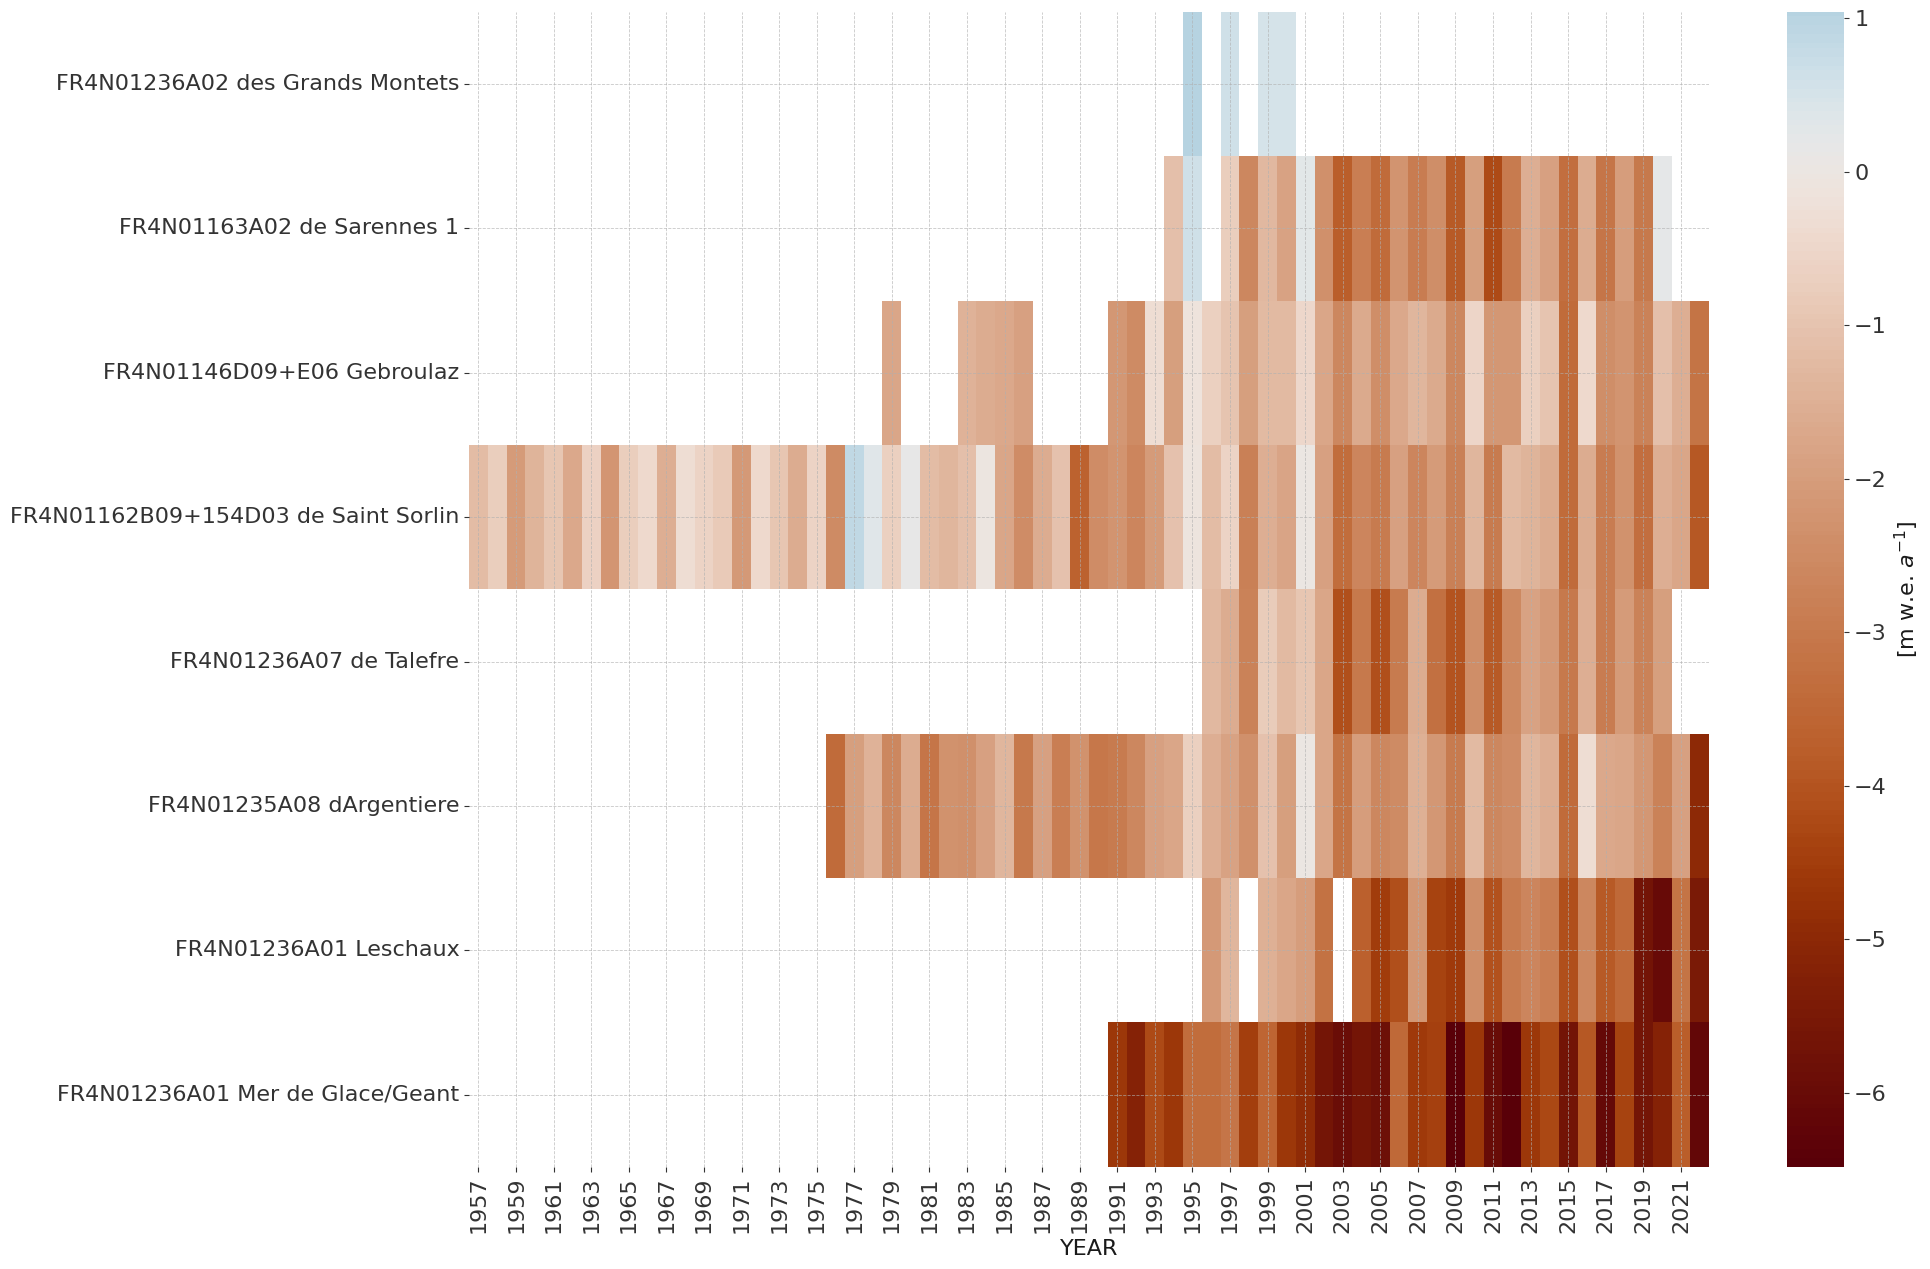

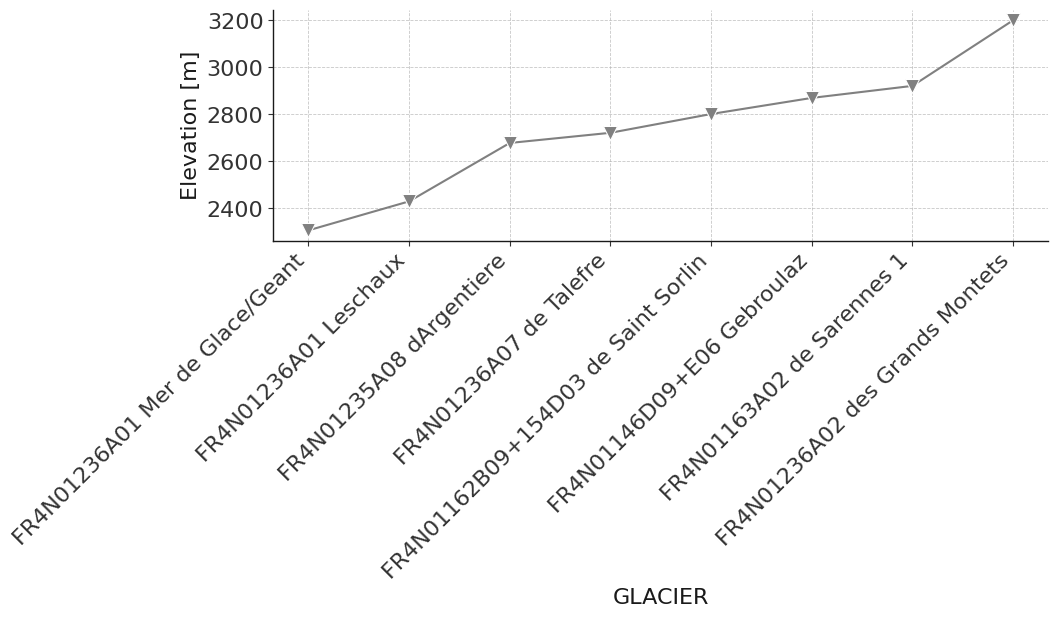

In [5]:
plotHeatmap(data_monthly, period='annual', plot_elevation=True)

Text(0.5, 1.0, 'Number of measurements per year for all glaciers')

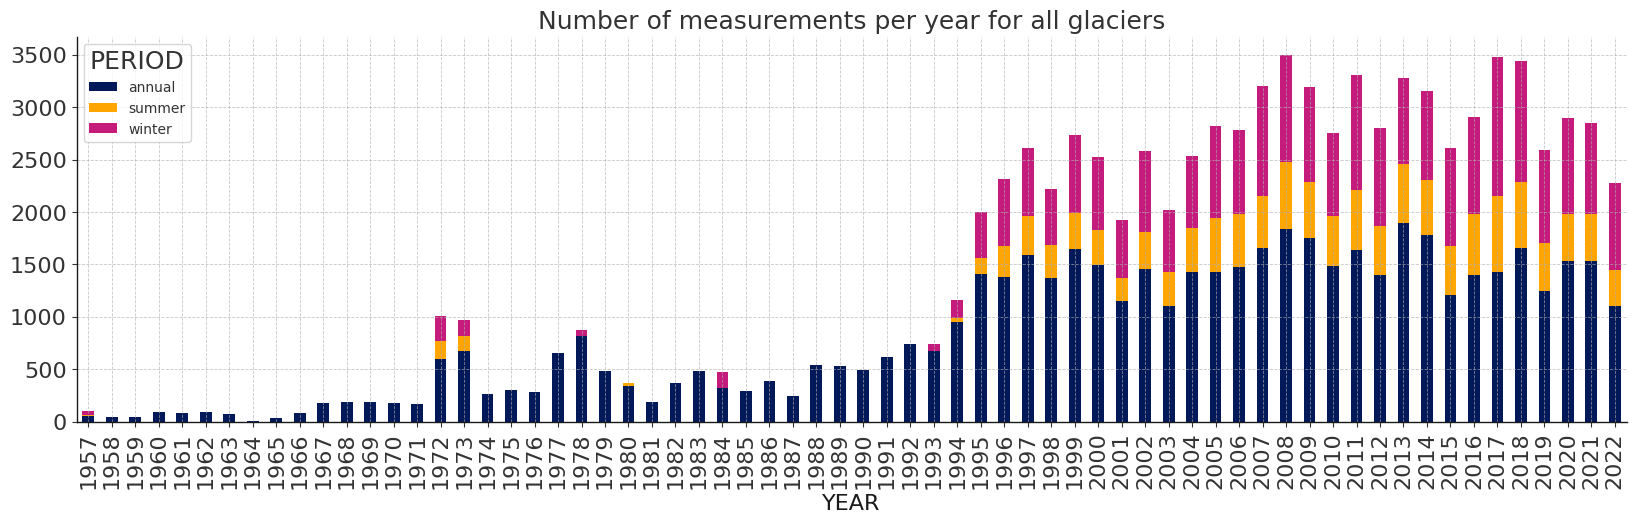

In [6]:
data_monthly.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_orange, color_pink])
plt.title('Number of measurements per year for all glaciers')


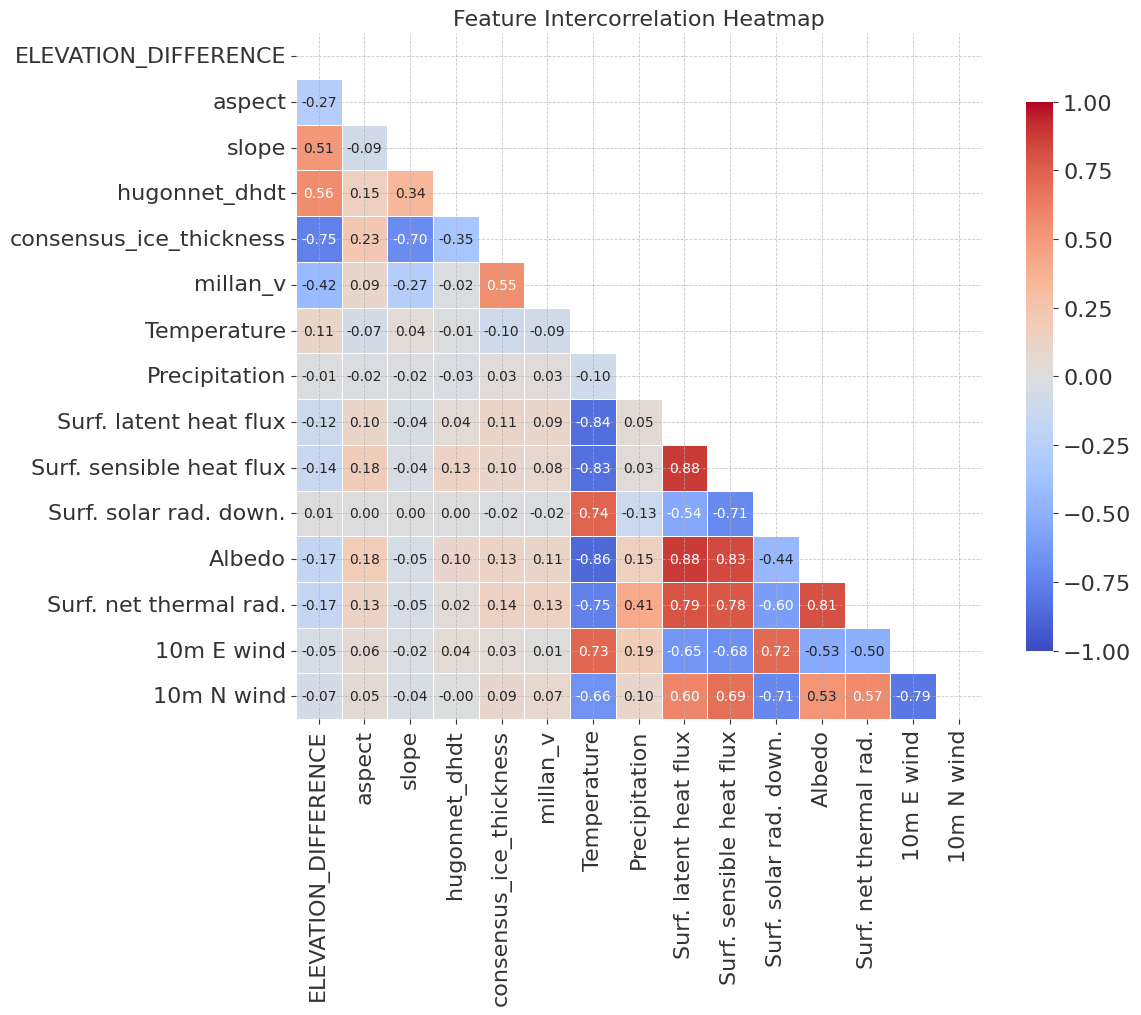

In [7]:
# Plot feature intercorrelation
plot_feature_correlation(dataloader_gl.data)


### Sanity checks:

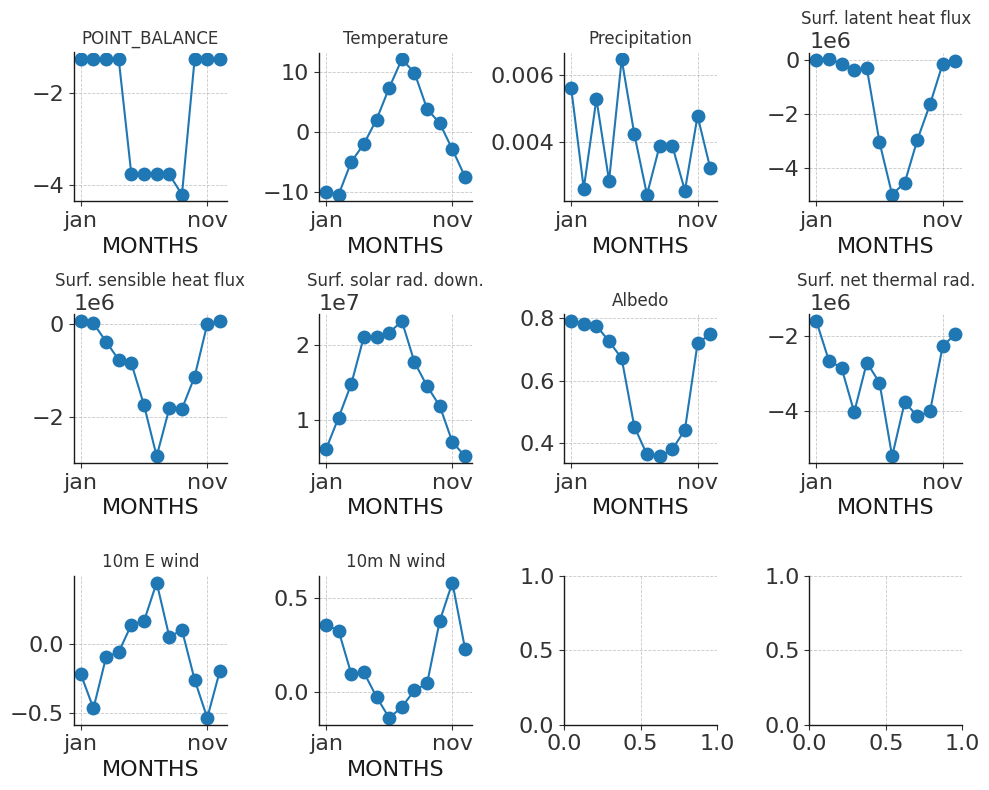

In [8]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate
df = df[(df.GLACIER == 'FR4N01235A08 dArgentiere') & (df.YEAR == 2015)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

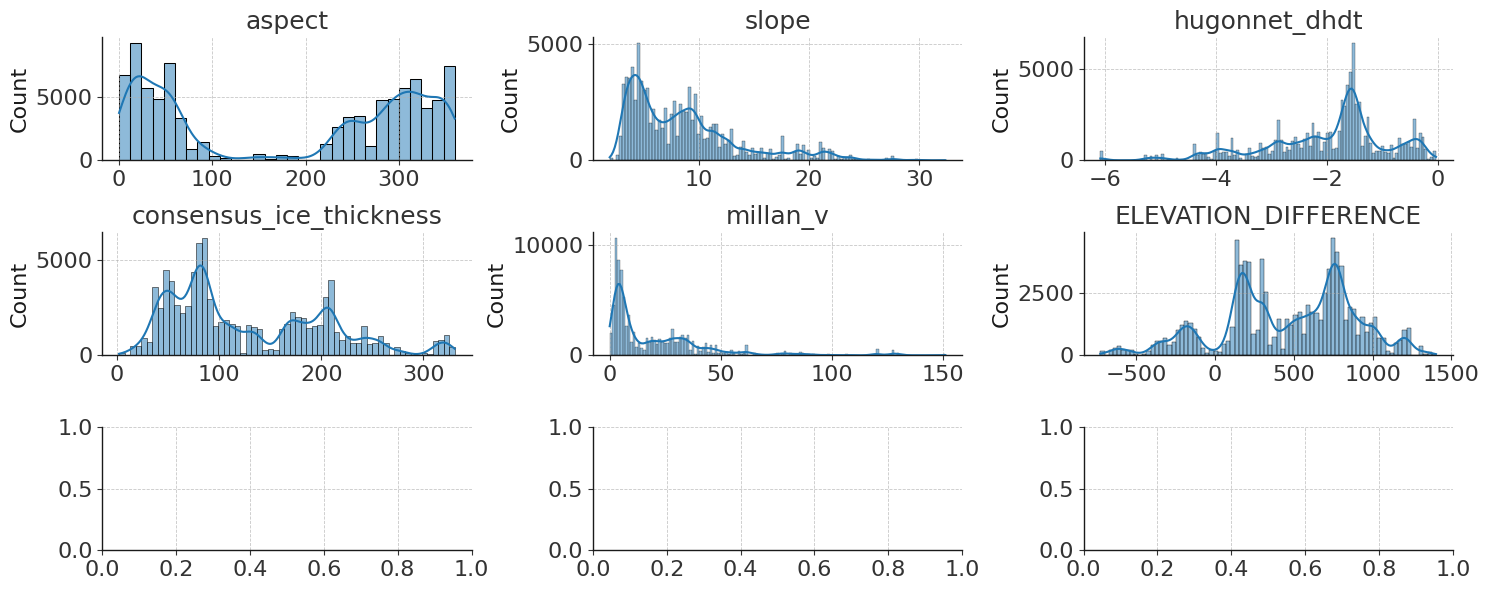

In [9]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

### A.3. Train-test set split:
##### A.3.1. Spatial Cross-Validation

###### Uses specific glaciers as test set

In [11]:
test_glaciers = ['FR4N01146D09+E06 Gebroulaz']

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))



Size of test data: 14997
Size of train data: 76378
Percentage of test size: 19.64%
Train glaciers: (7) ['FR4N01235A08 dArgentiere' 'FR4N01236A02 des Grands Montets'
 'FR4N01236A01 Mer de Glace/Geant' 'FR4N01236A01 Leschaux'
 'FR4N01236A07 de Talefre' 'FR4N01163A02 de Sarennes 1'
 'FR4N01162B09+154D03 de Saint Sorlin']
Test glaciers: (1) ['FR4N01146D09+E06 Gebroulaz']


###### train-test set plots

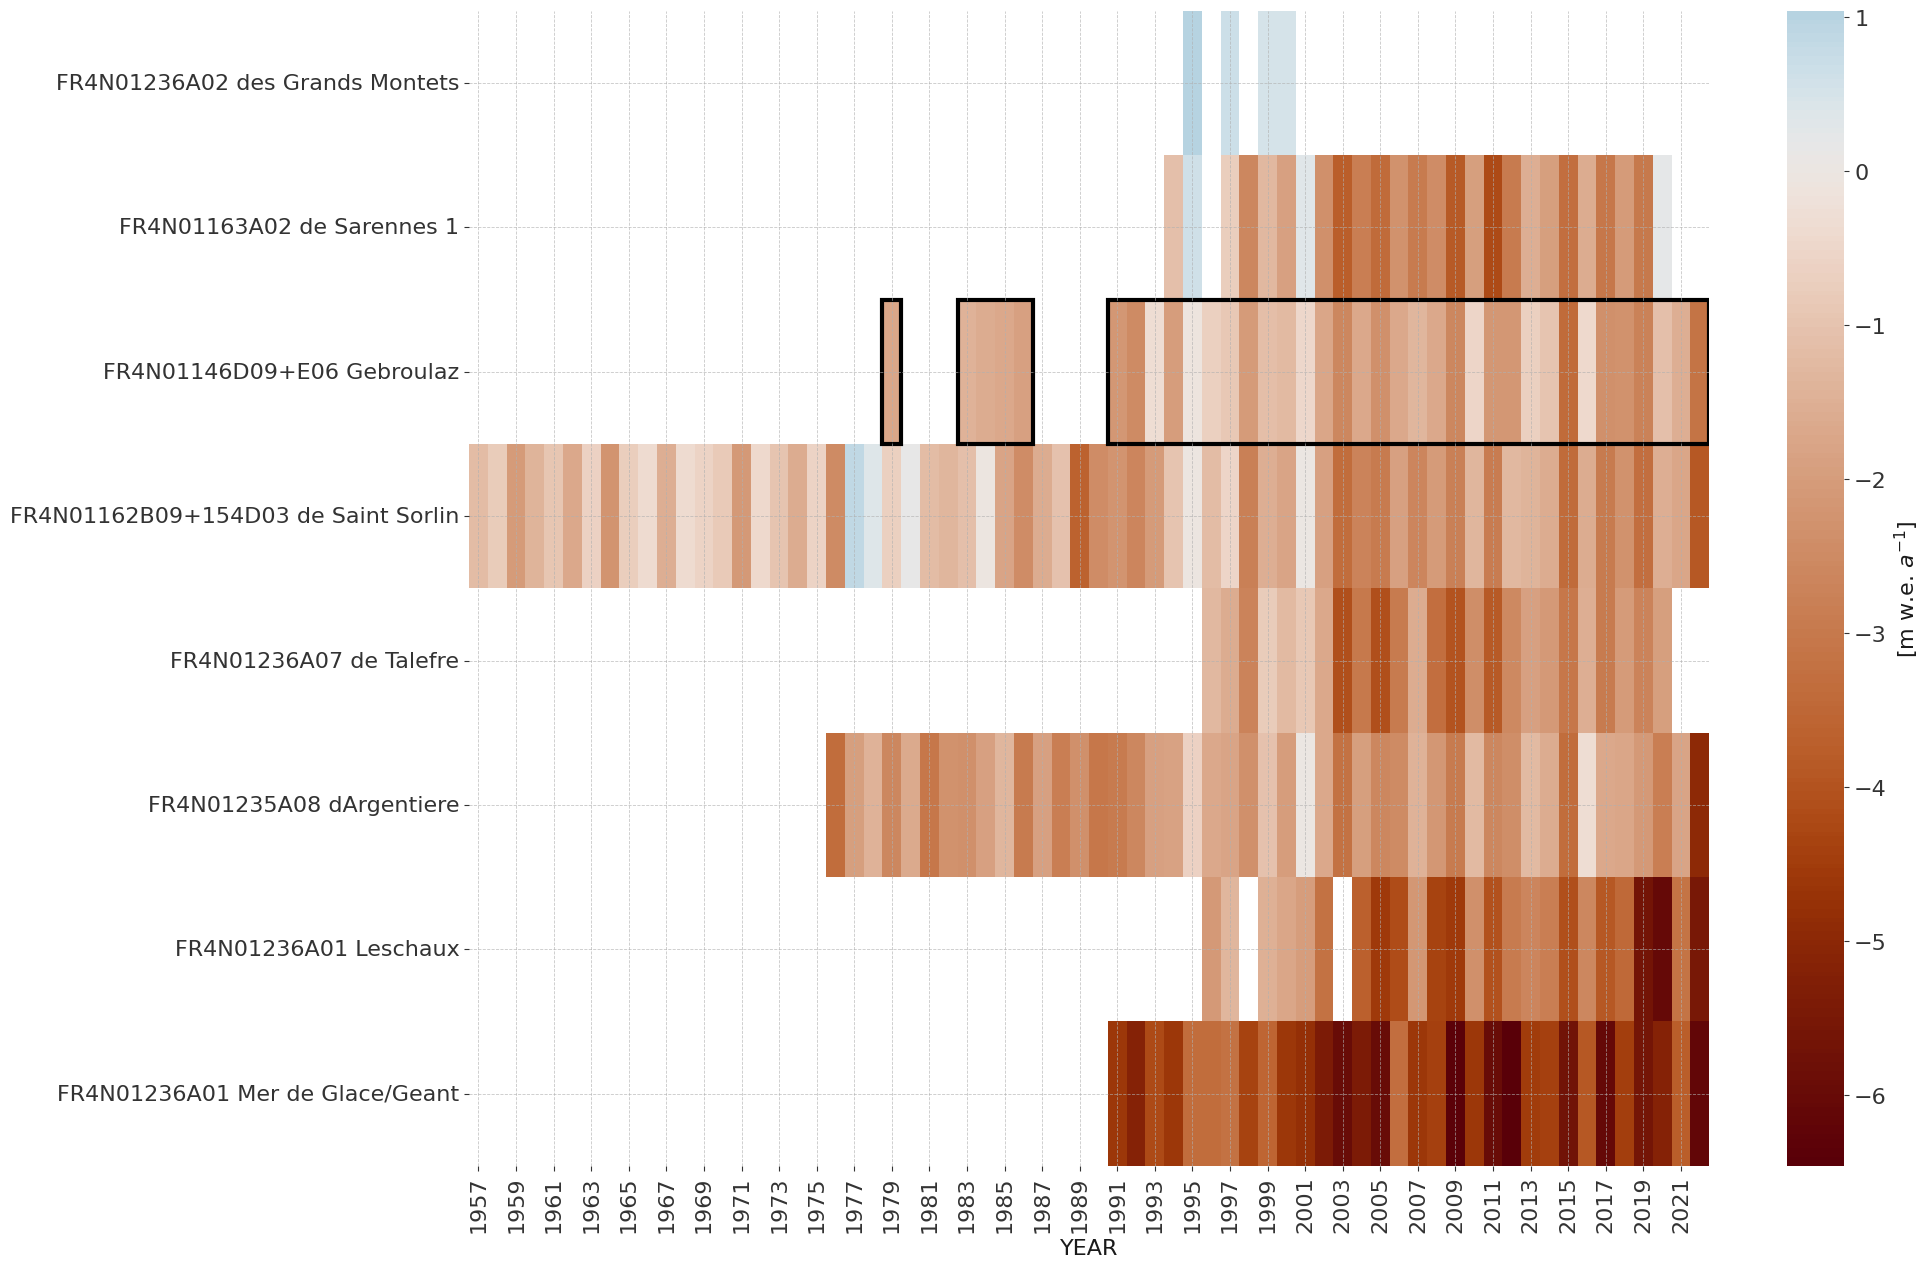

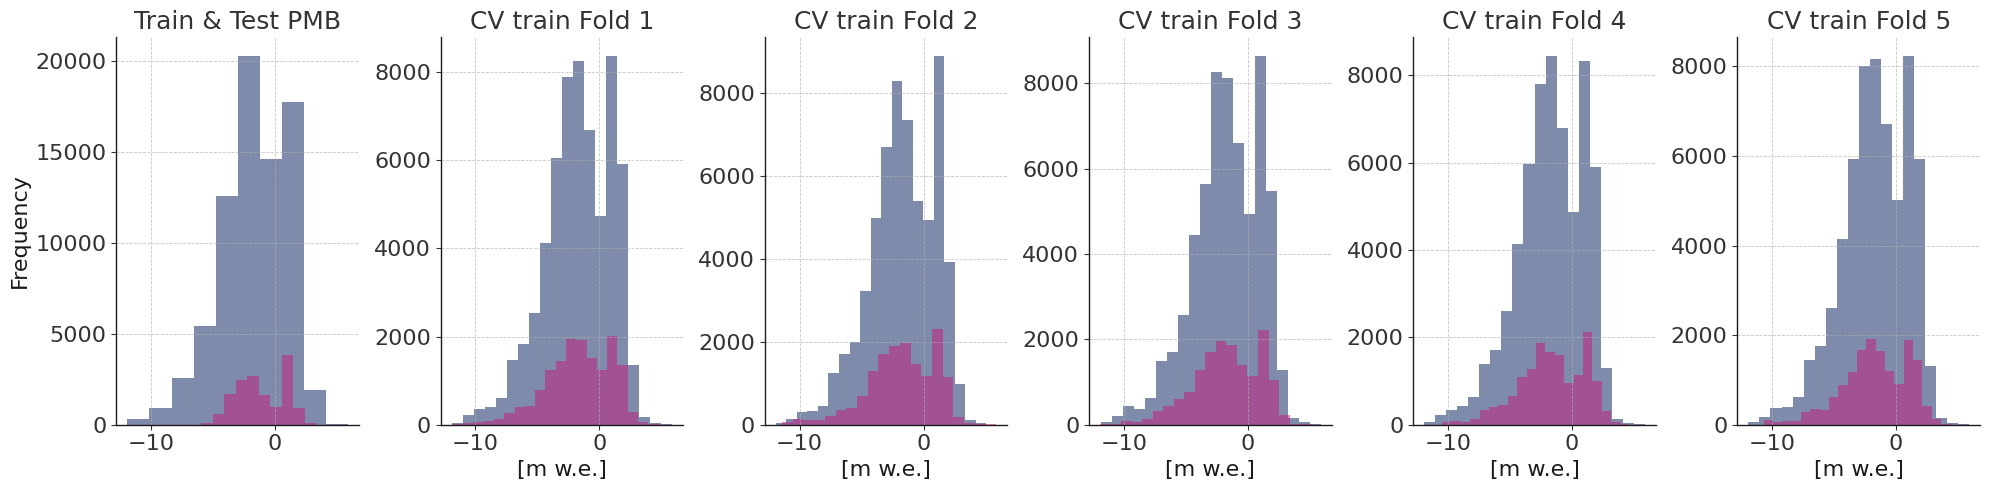

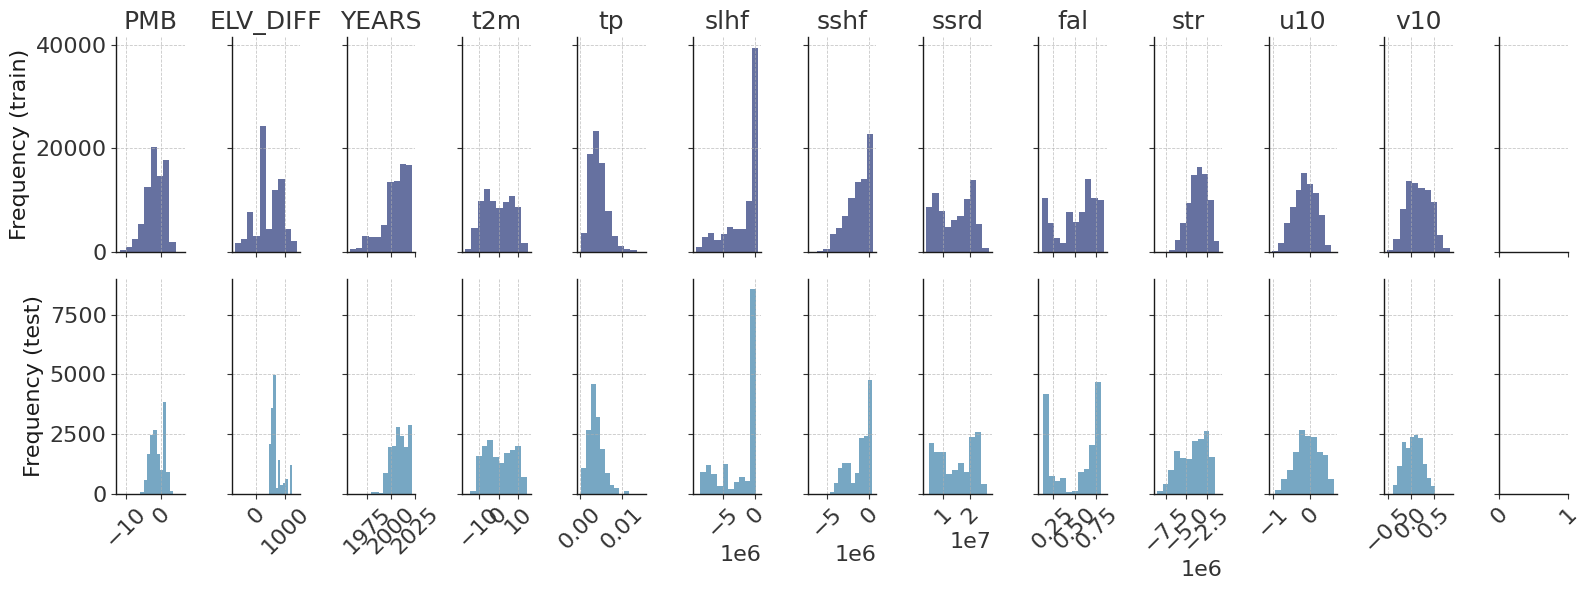

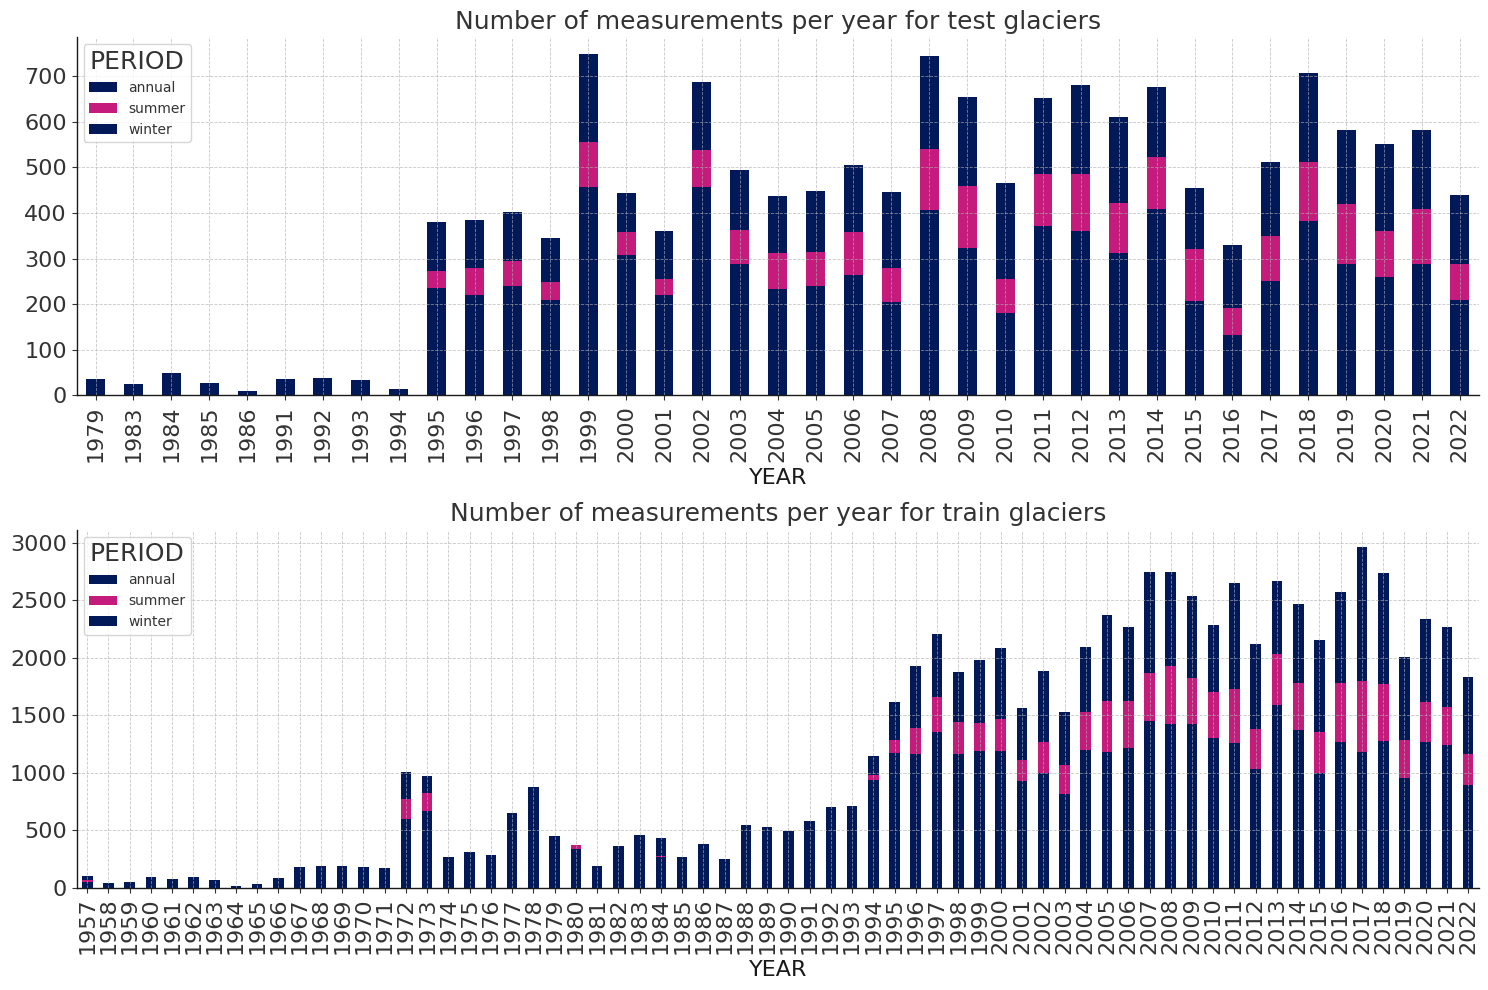

In [12]:
plotHeatmap(data_glacioclim, test_glaciers, period='annual')
#plotHeatmap(data_glacioclim, test_glaciers, period='winter')
#plotHeatmap(data_glacioclim, test_glaciers, period='summer')
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

##### A.3.2. Temporal Cross-Validation

###### Uses the last X years as test set

In [10]:
test_years_count = 10

all_years = sorted(dataloader_gl.data['YEAR'].unique())

# Use the most recent years as test data
train_years = all_years[:-test_years_count]
test_years = all_years[-test_years_count:]

# Statistics prints
print('Size of test data:', len(test_years))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_years)]
print('Size of train data:', len(train_years))
if len(train_years) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(test_years) / len(train_years)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(
                                dataloader_gl,
                                test_split_on='YEAR',
                                test_splits=test_years,
                                random_state=cfg.seed)



print('Train year: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test years: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))



Size of test data: 10
Size of train data: 56
Percentage of test size: 17.86%
Train year: (56) [2006 2007 2008 2009 2010 2011 2012 1994 1995 1996 1997 1998 1999 2000
 2001 2002 2003 2004 2005 1993 1976 1977 1978 1979 1980 1981 1982 1983
 1984 1985 1986 1987 1988 1989 1990 1991 1992 1957 1958 1959 1960 1961
 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975]
Test years: (10) [2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


###### train-test set plots

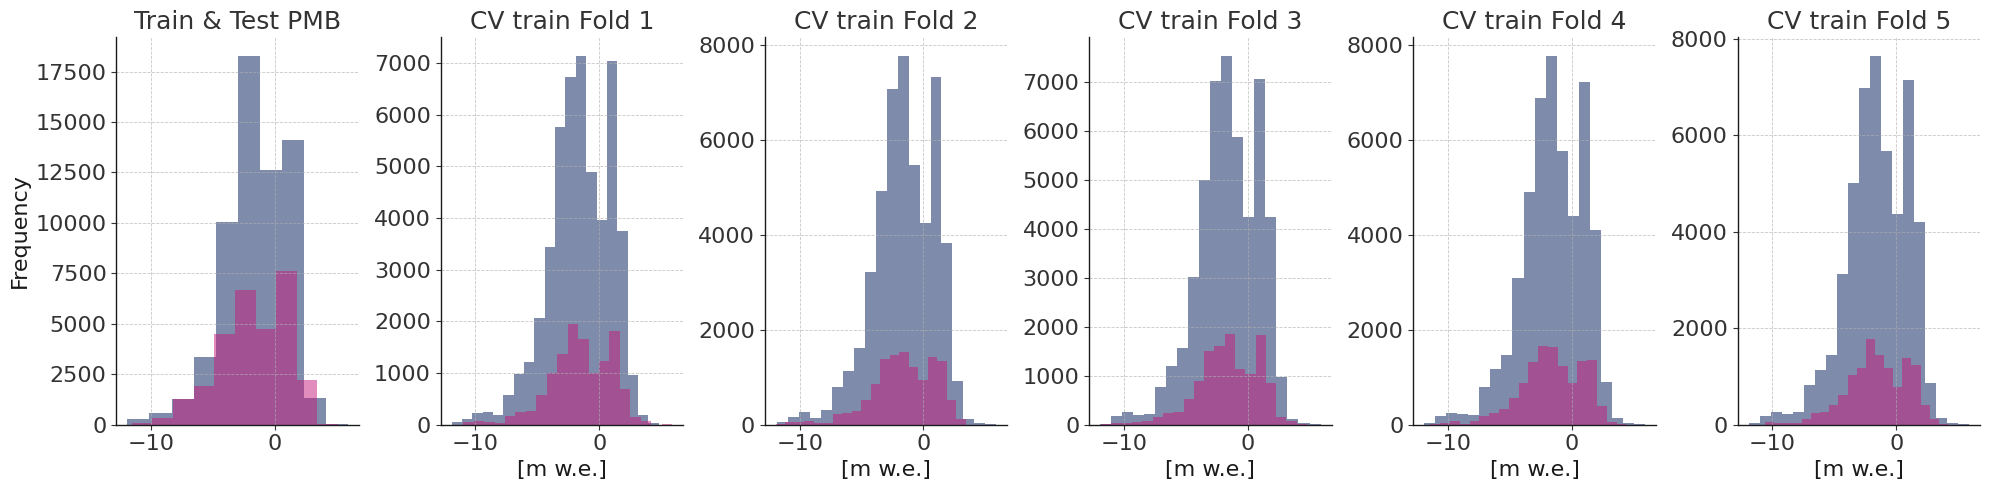

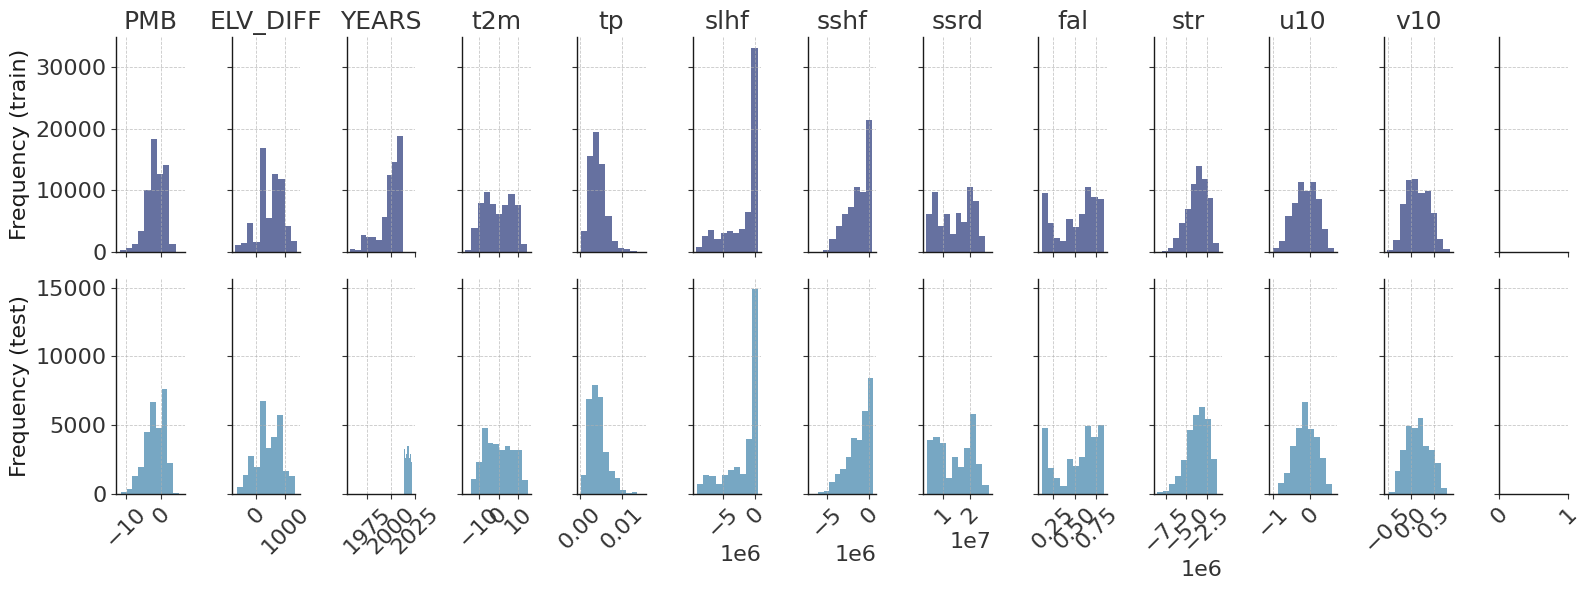

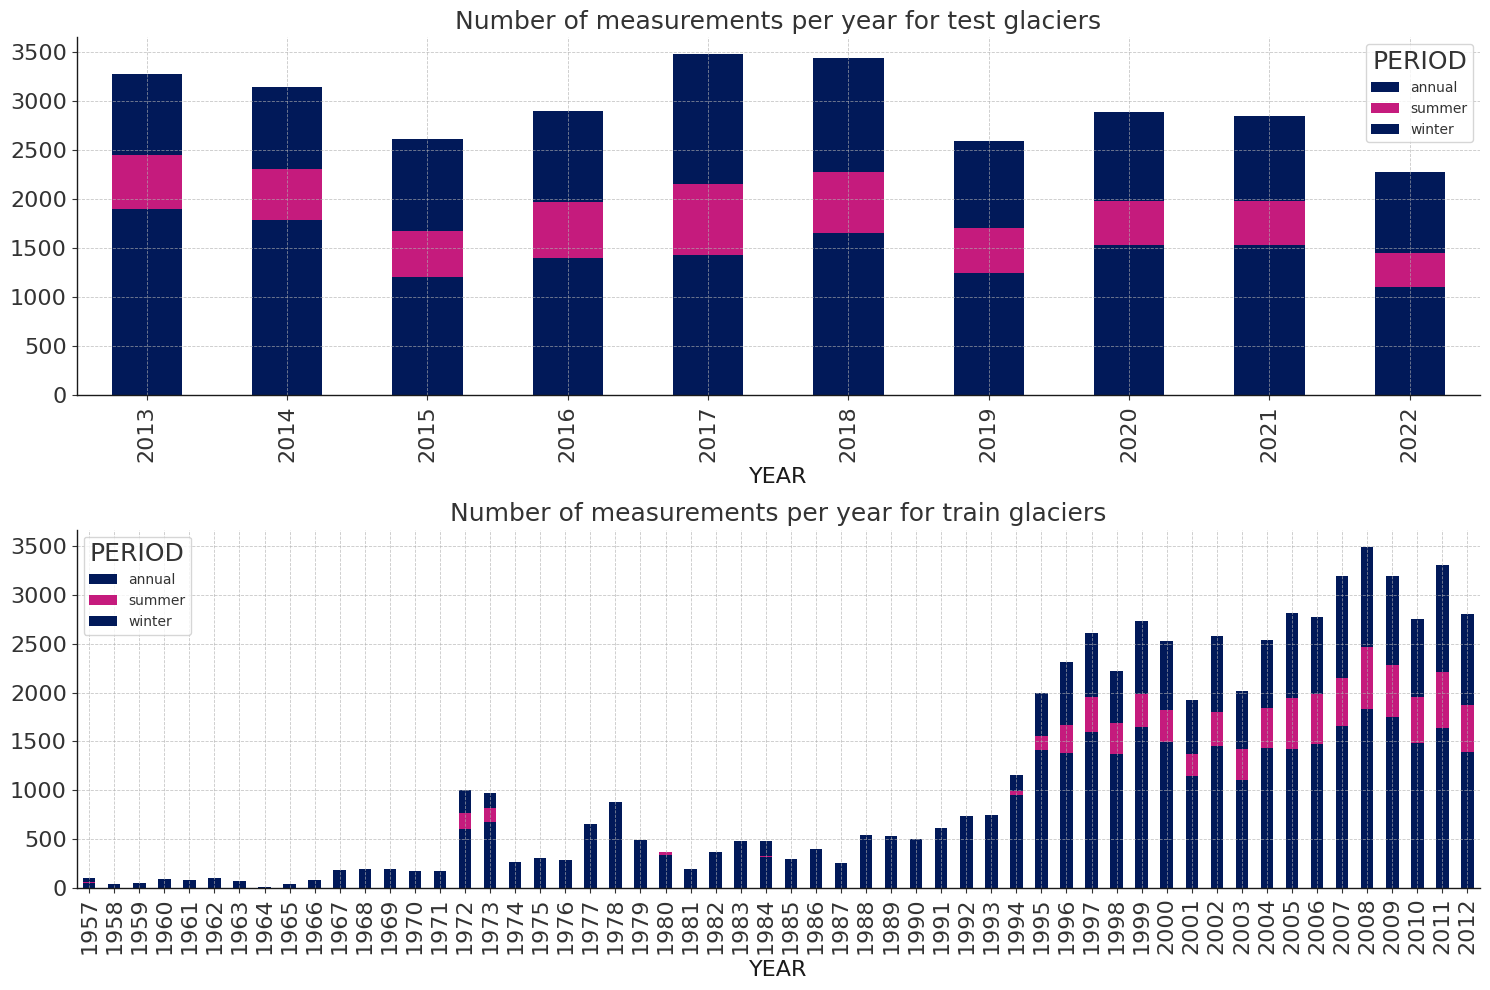

In [11]:
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

#### A.4. XGBoost:

In [12]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs


vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

In [13]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_Gebroulaz_reworked_03_06.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_reworked_03_06_temporal_10years.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (61898, 27)
Shape of testing dataset: (29477, 27)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v']
Best parameters:
 {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1}
Best score:
 -0.16918096815551675
Shape of the test: (29477, 15)
Overall score: 0.568648139588403
CPU times: user 3.02 s, sys: 73.9 ms, total: 3.09 s
Wall time: 177 ms


###### Results

In [ ]:
# visualiseValPreds(best_estimator, splits, train_set, feature_columns)

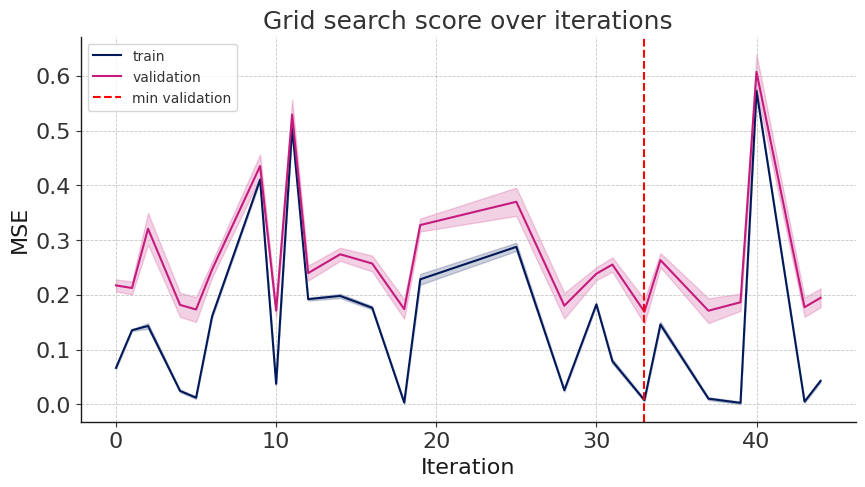

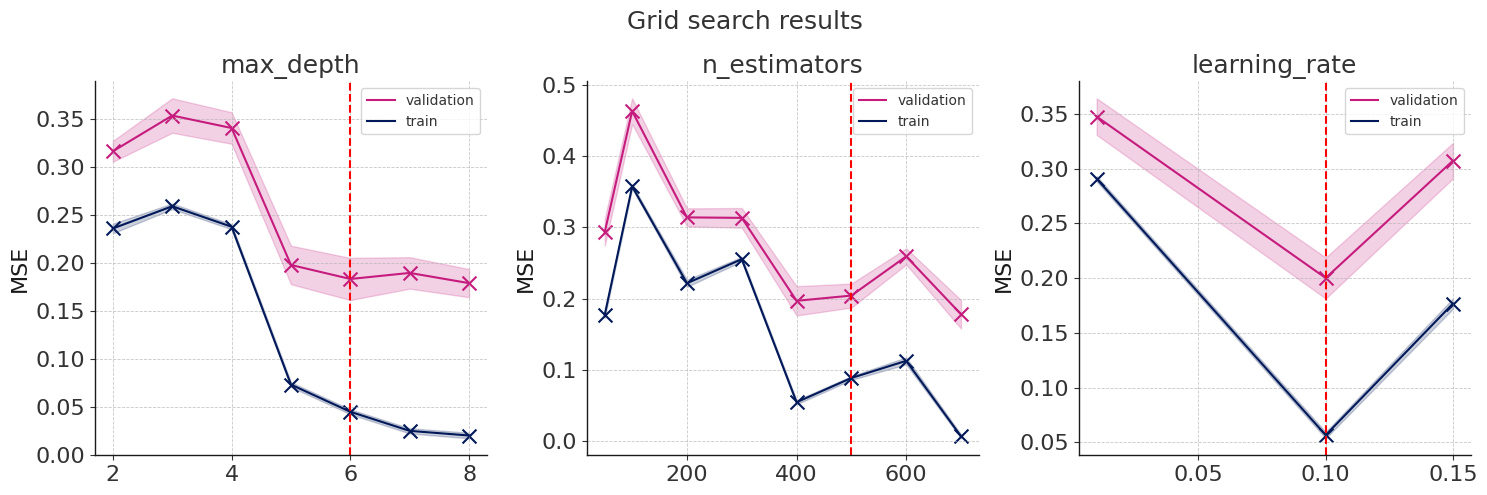

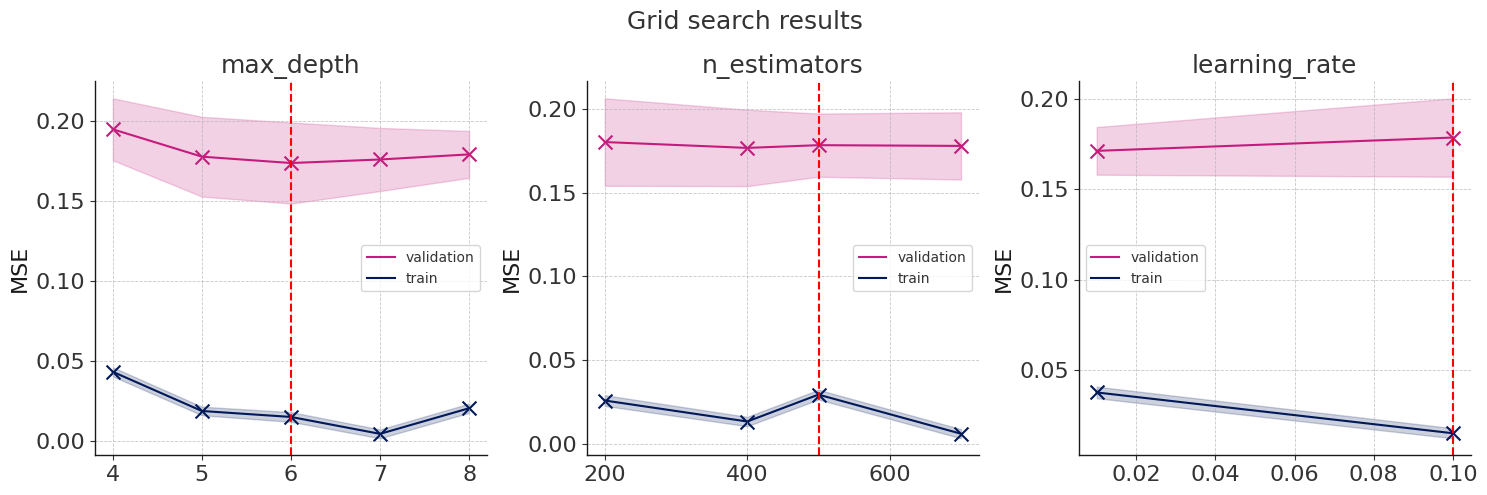

In [ ]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

print_top_n_models(custom_xgboost.param_search.cv_results_)

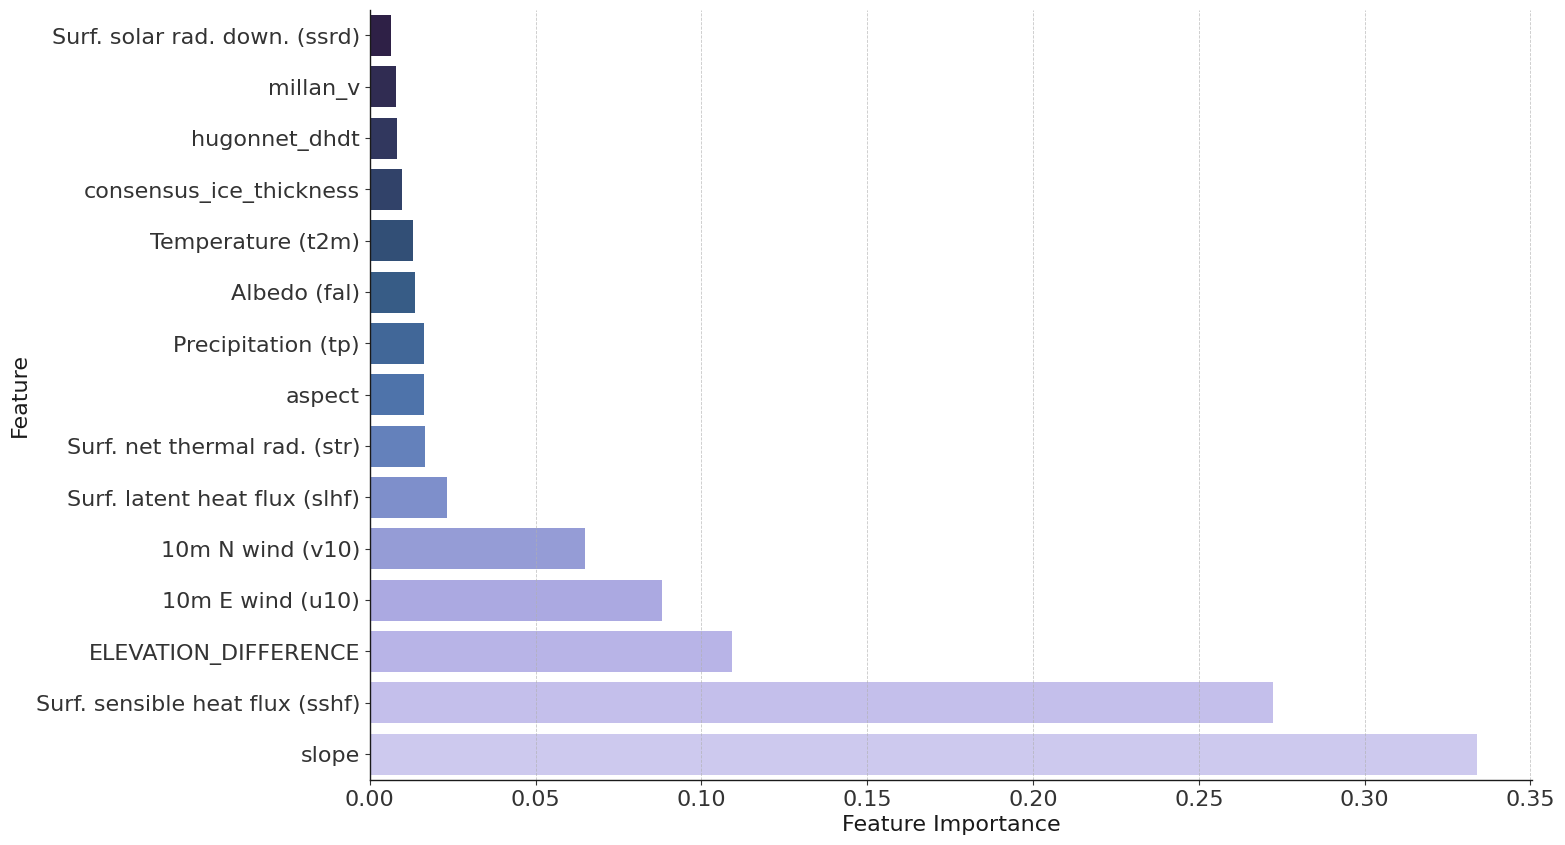

In [15]:
FIPlot(best_estimator, feature_columns, vois_climate)

###### Predictions of best parameters

Shape of the test: (29477, 15)


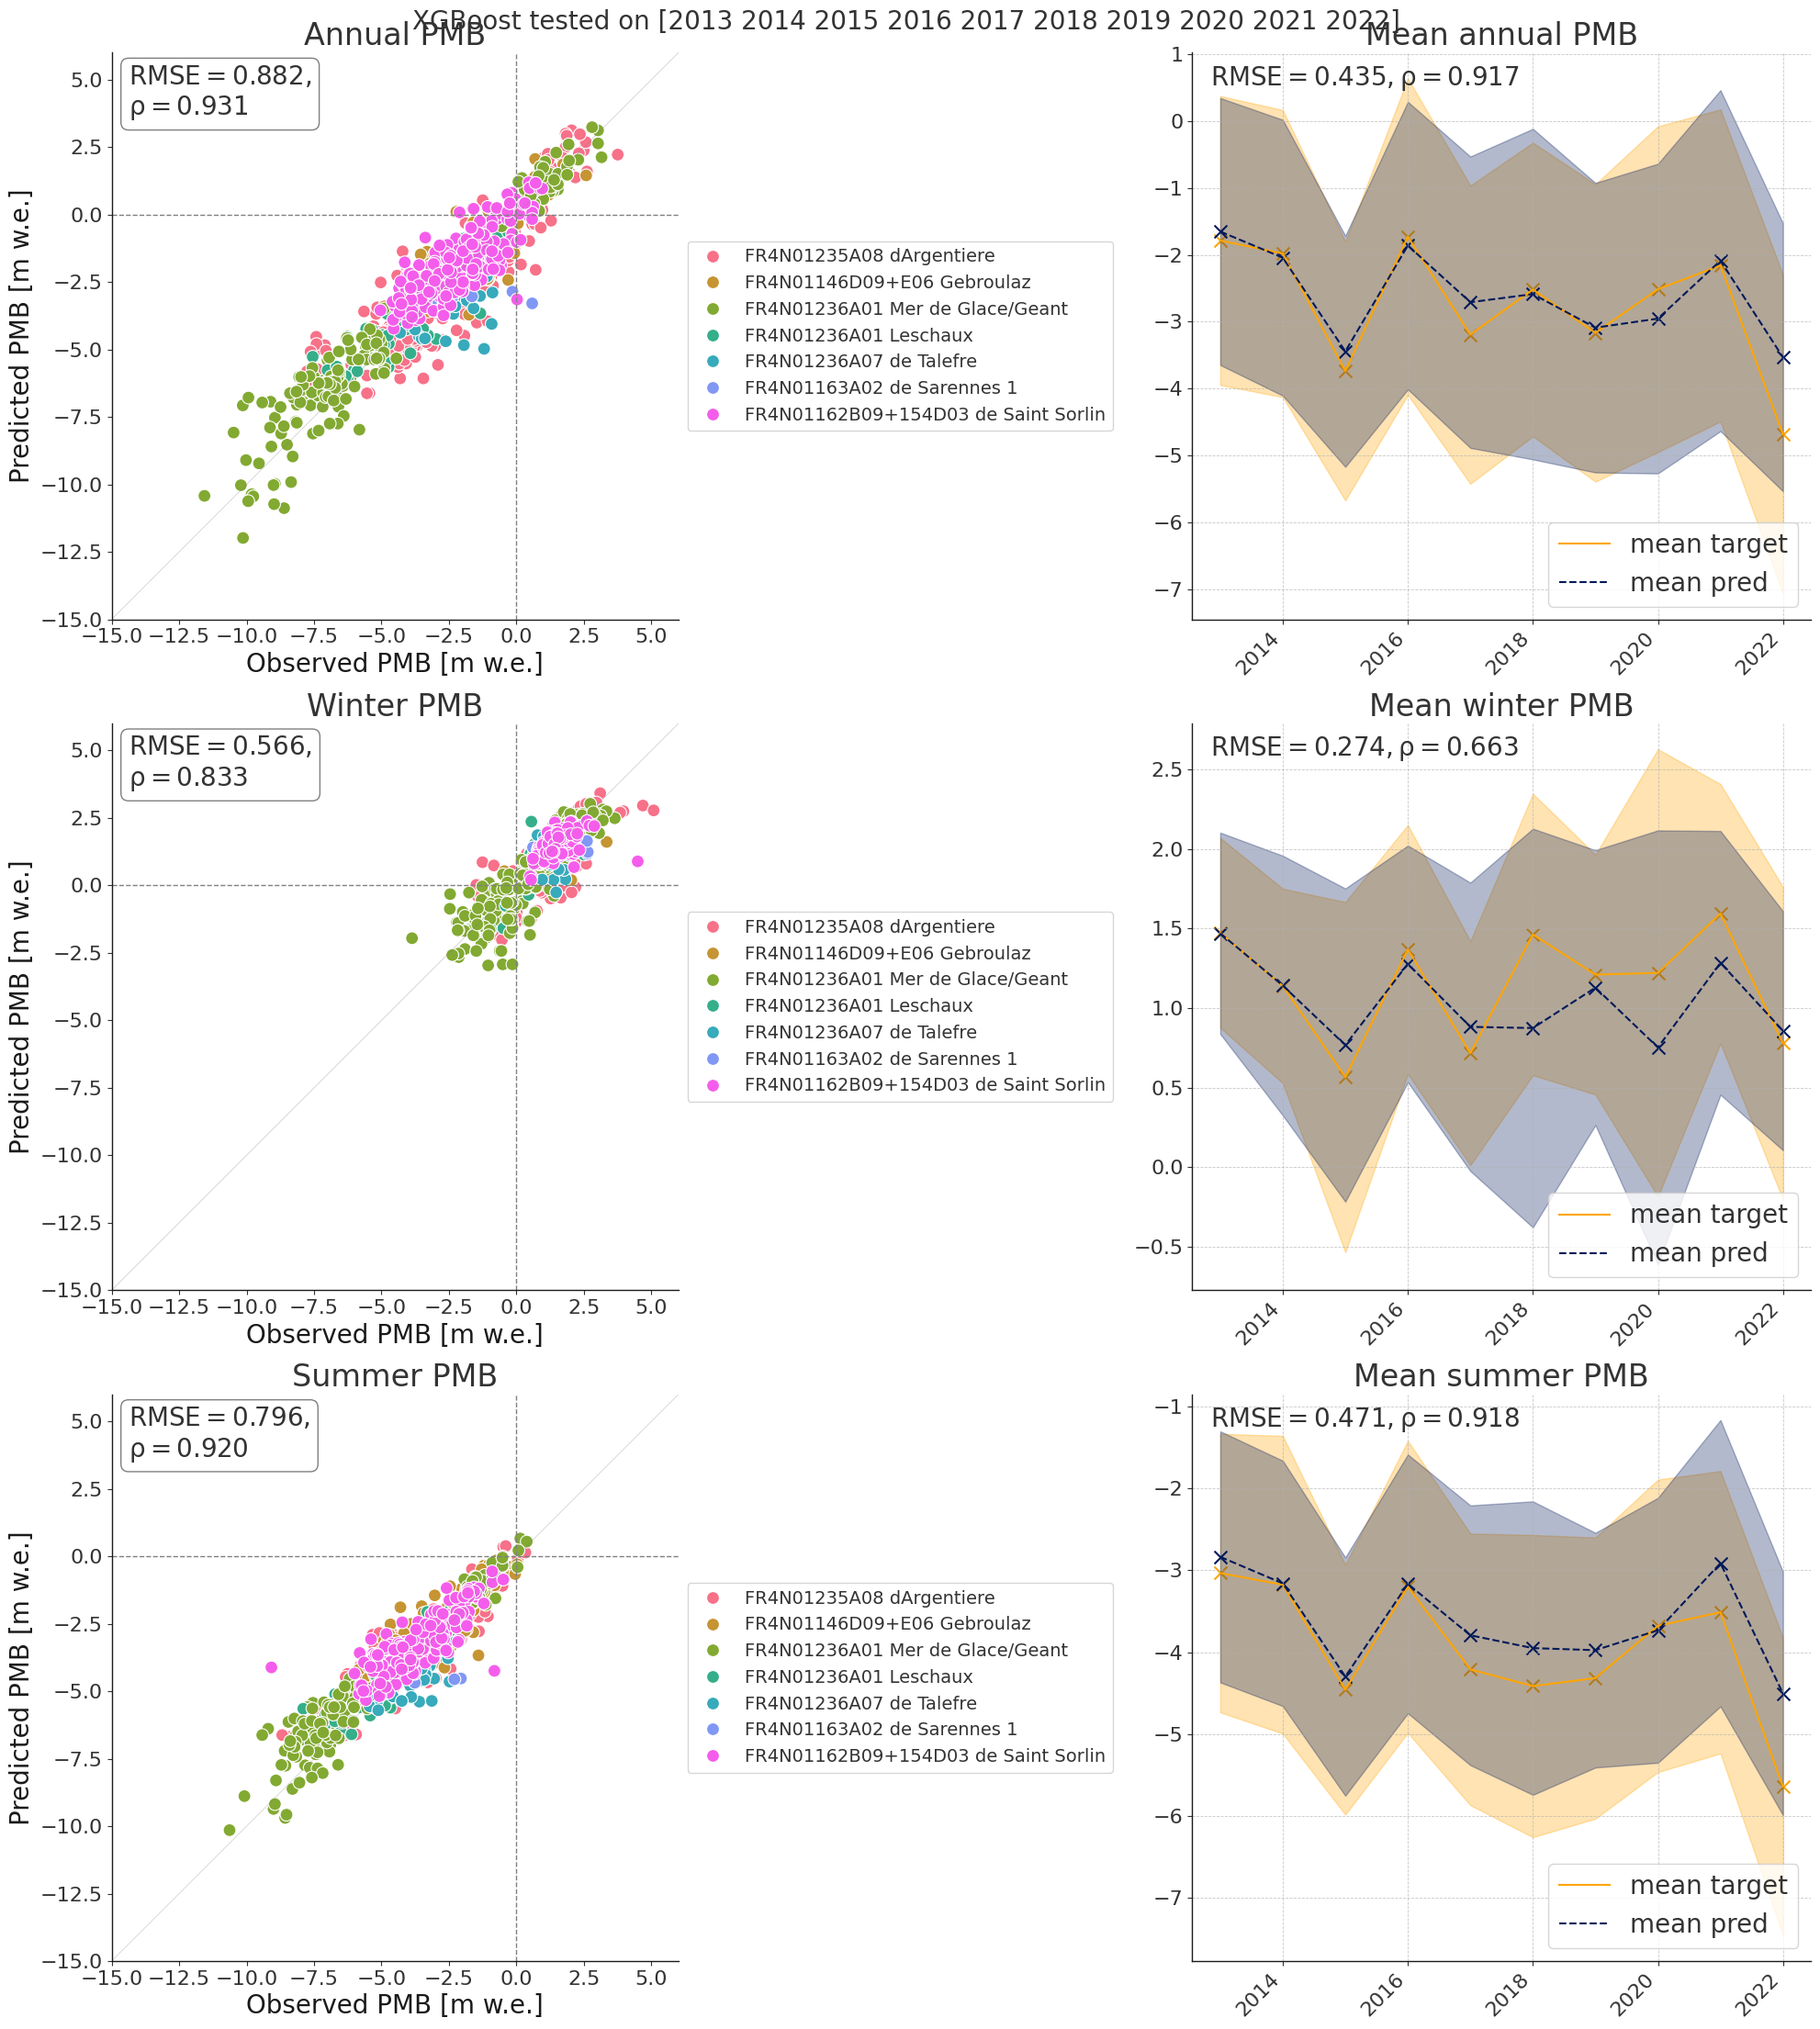

In [16]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, include_summer=True)
plt.suptitle(f'XGBoost tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

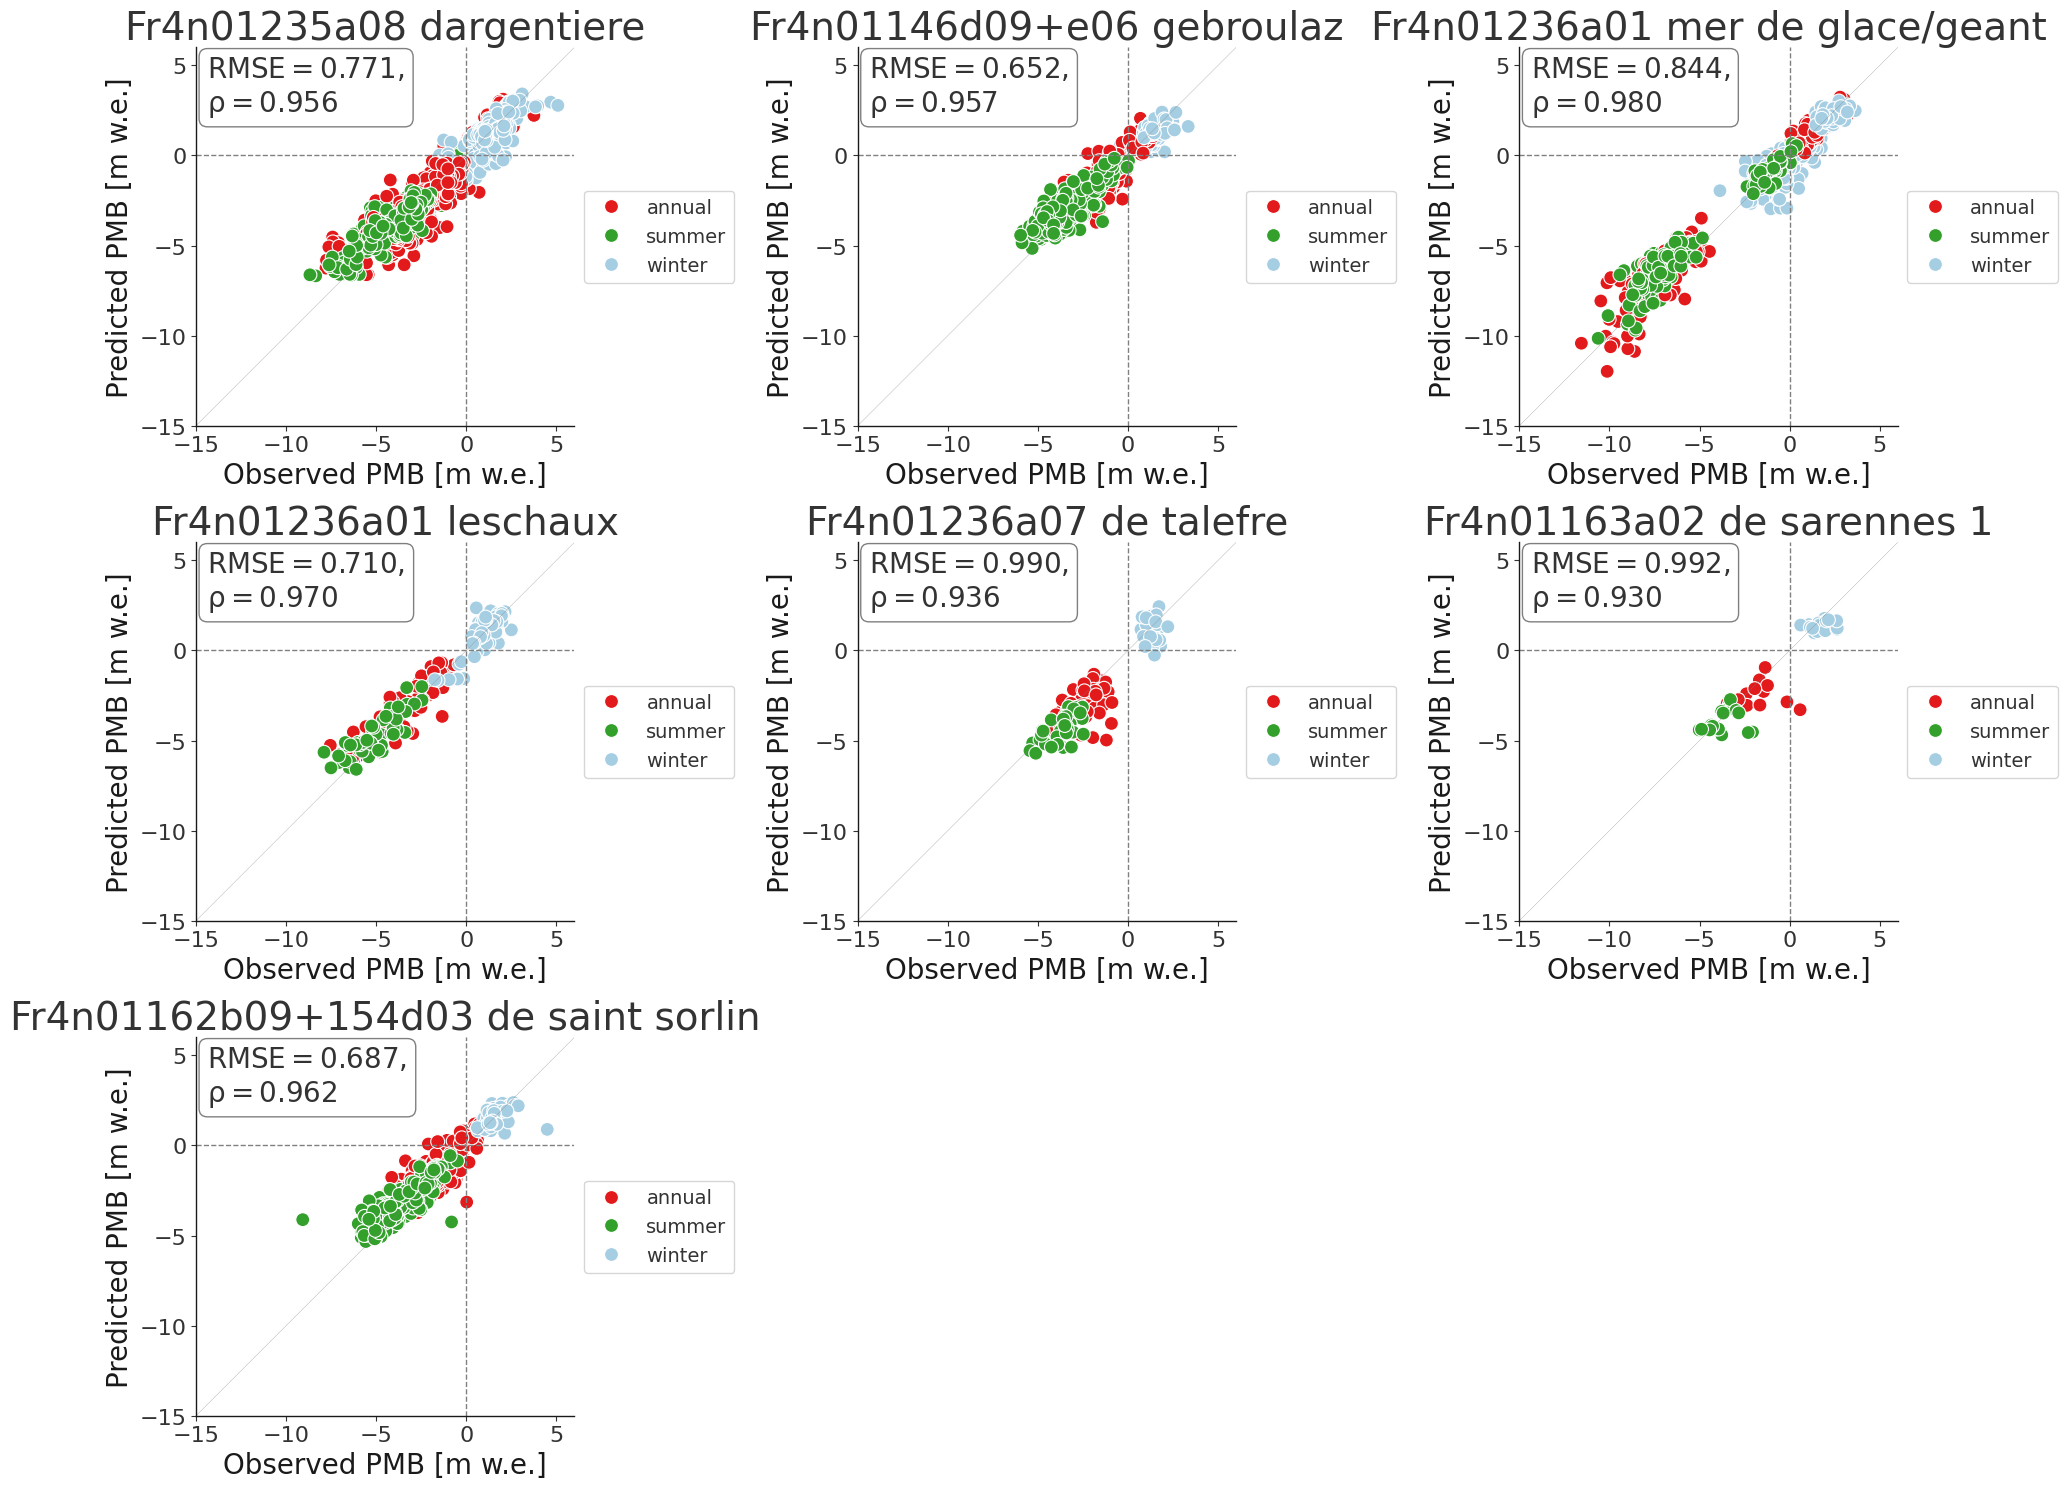

In [20]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

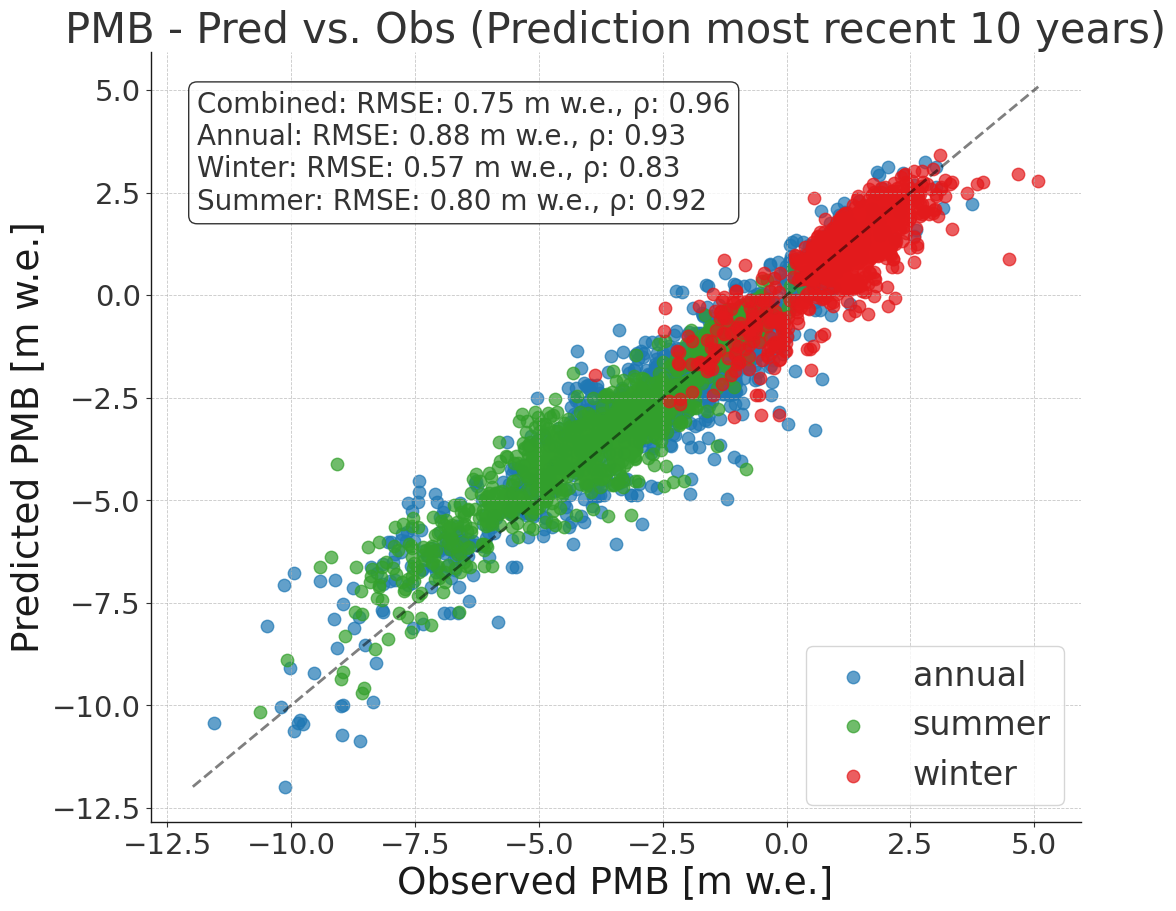

In [21]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='Prediction most recent 10 years', include_summer = True)

### B.1. Train CH Test FR

In [8]:
# Read in
data_FR = pd.read_csv(path_PMB_GLACIOCLIM_csv + 'FR_wgms_dataset_all_oggm.csv')
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
# Adjust dfs to match
data_CH['GLACIER_ZONE'] = 'Placeholder'
data_CH['DATA_MODIFICATION'] = ''
data_CH = data_CH.drop(columns=['aspect_sgi', 'slope_sgi', 'topo_sgi'], errors='ignore')

data_FR = data_FR[data_FR['PERIOD'] != 'summer']

# Merge FR with CH
data_FR_CH = pd.concat([data_FR, data_CH], axis=0).reset_index(drop=True)

display(len(data_FR_CH['GLACIER'].unique()))

47

In [11]:
display(data_FR_CH[data_FR_CH.isna().any(axis=1)])

Empty DataFrame
Columns: [POINT_ID, POINT_LAT, POINT_LON, POINT_ELEVATION, FROM_DATE, TO_DATE, POINT_BALANCE, GLACIER, PERIOD, GLACIER_ZONE, YEAR, RGIId, aspect, slope, topo, hugonnet_dhdt, consensus_ice_thickness, millan_v]
Index: []

In [9]:
data_FR_CH = data_FR_CH.drop(columns=['DATA_MODIFICATION'])

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': path_PMB_GLACIOCLIM_csv,
    'era5_climate_data': path_ERA5_raw + 'era5_monthly_averaged_data_Alps.nc',
    'geopotential_data': path_ERA5_raw + 'era5_geopotential_pressure_Alps.nc'
}

RUN = True
dataloader_gl = process_or_load_data_glacioclim(run_flag=RUN,
                                     df=data_FR_CH,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'FR_CH_wgms_dataset_monthly_full.csv')
data_monthly_FR_CH = dataloader_gl.data

display(data_monthly_FR_CH.head(2))

2025-06-09 19:19:46,543 - INFO - Number of annual and seasonal samples: 41158
2025-06-09 19:19:46,546 - INFO - Running on 47 glaciers:
['FR4N01235A08 dArgentiere' 'FR4N01146D09+E06 Gebroulaz'
 'FR4N01236A01 Mer de Glace/Geant' 'FR4N01236A01 Leschaux'
 'FR4N01236A07 de Talefre' 'FR4N01163A02 de Sarennes 1'
 'FR4N01162B09+154D03 de Saint Sorlin' 'FR4N01236A02 des Grands Montets'
 'adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen'
 'clariden' 'corbassiere' 'corvatsch' 'damma' 'findelen' 'forno' 'gietro'
 'gorner' 'gries' 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel'
 'oberaar' 'otemma' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna'
 'sardona' 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta'
 'taelliboden' 'tiefen' 'tortin' 'tsanfleuron' 'vorab' 'witenwasseren']
2025-06-09 19:19:46,600 - INFO - Number of winter, summer and annual samples: 41158
2025-06-09 19:19:46,605 - INFO - Number of annual samples: 11825
2025-06-09 19:19:46,611 - INFO - Number of winter 

KeyError: "['t2m_nan', 'tp_nan', 'slhf_nan', 'sshf_nan', 'ssrd_nan', 'fal_nan', 'str_nan', 'u10_nan', 'v10_nan'] not in index"

In [ ]:
test_glaciers = list(data_FR['GLACIER'].unique())

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = list(data_CH['GLACIER'].unique())
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))



Size of test data: 78460
Size of train data: 290682
Percentage of test size: 26.99%
Train:
Number of winter and annual samples: 290682
Number of annual samples: 87440
Number of winter samples: 203242
Test:
Number of winter and annual samples: 78460
Number of annual samples: 54295
Number of winter samples: 24165
Total:
Number of monthly rows: 369142
Number of annual rows: 141735
Number of winter rows: 227407


Test glaciers: (8) ['FR4N01235A08 dArgentiere' 'FR4N01236A02 des Grands Montets'
 'FR4N01146D09+E06 Gebroulaz' 'FR4N01236A01 Mer de Glace/Geant'
 'FR4N01236A01 Leschaux' 'FR4N01236A07 de Talefre'
 'FR4N01163A02 de Sarennes 1' 'FR4N01162B09+154D03 de Saint Sorlin']
Percentage of test size: 26.99%
Size of test set: 78460
Train glaciers: (39) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen'
 'clariden' 'corbassiere' 'corvatsch' 'damma' 'findelen' 'forno' 'gietro'
 'gorner' 'gries' 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel'
 'oberaar' 'otemma' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna'
 'sardona' 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta'
 'taelliboden' 'tiefen' 'tortin' 'tsanfleuron' 'vorab' 'witenwasseren']
Size of train set: 290682


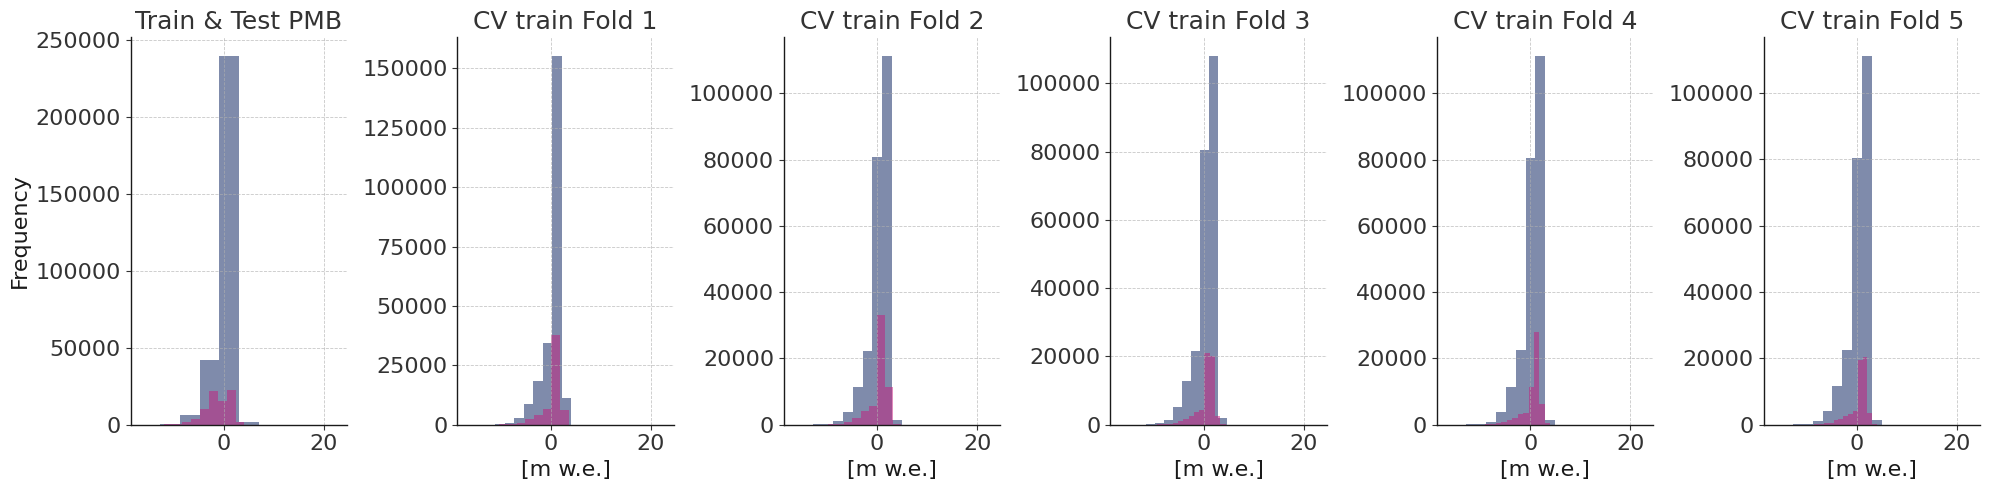

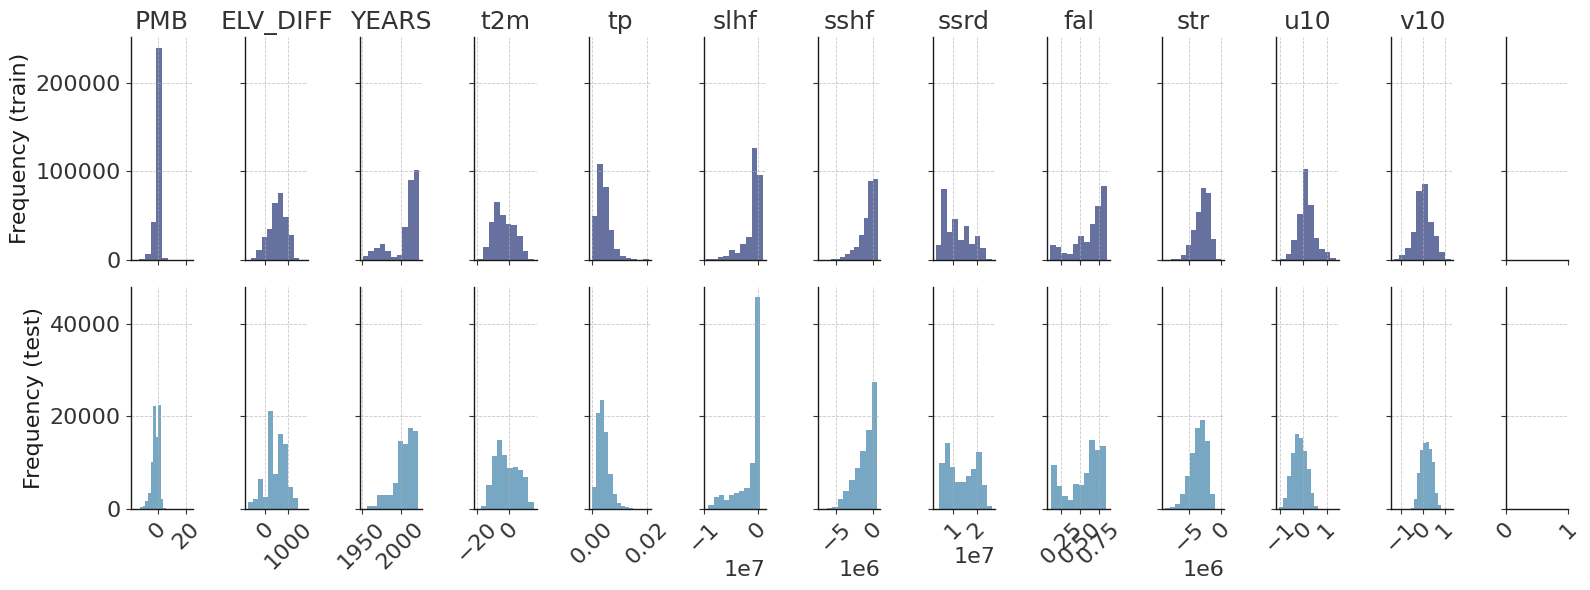

In [7]:
plotHeatmap(data_glacioclim, test_glaciers, period='annual')
#plotHeatmap(data_glacioclim, test_glaciers, period='winter')
#plotHeatmap(data_glacioclim, test_glaciers, period='summer')
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

#### XGBoost Transfer Region

In [8]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs


vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

In [9]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_CH_04_06.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_CH_04_06.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (290682, 27)
Shape of testing dataset: (78460, 27)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v']
Best parameters:
 {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01}
Best score:
 -0.195614192191449
Shape of the test: (78460, 15)
Overall score: 1.6852303958751689
CPU times: user 6.89 s, sys: 84 ms, total: 6.97 s
Wall time: 472 ms


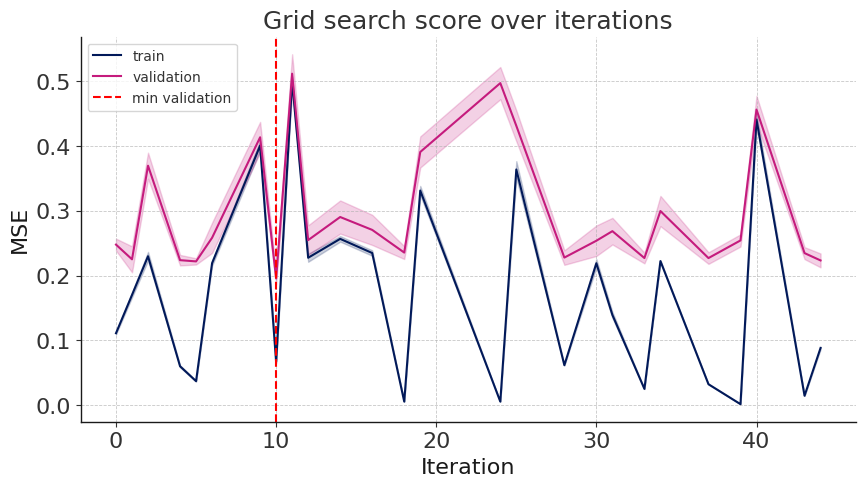

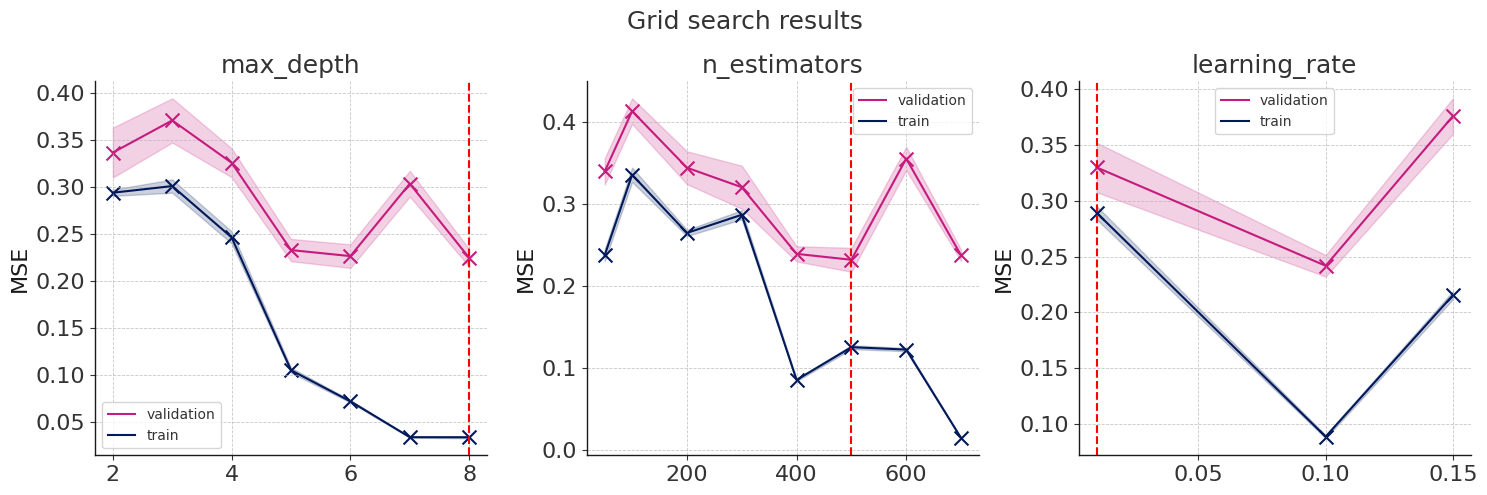

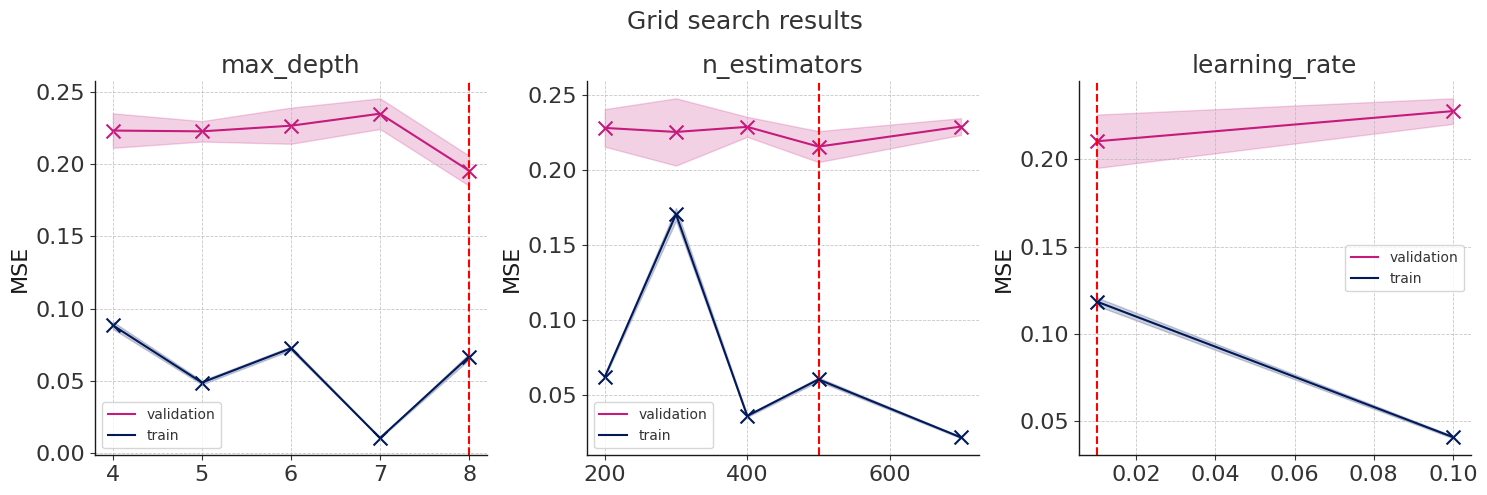

In [10]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

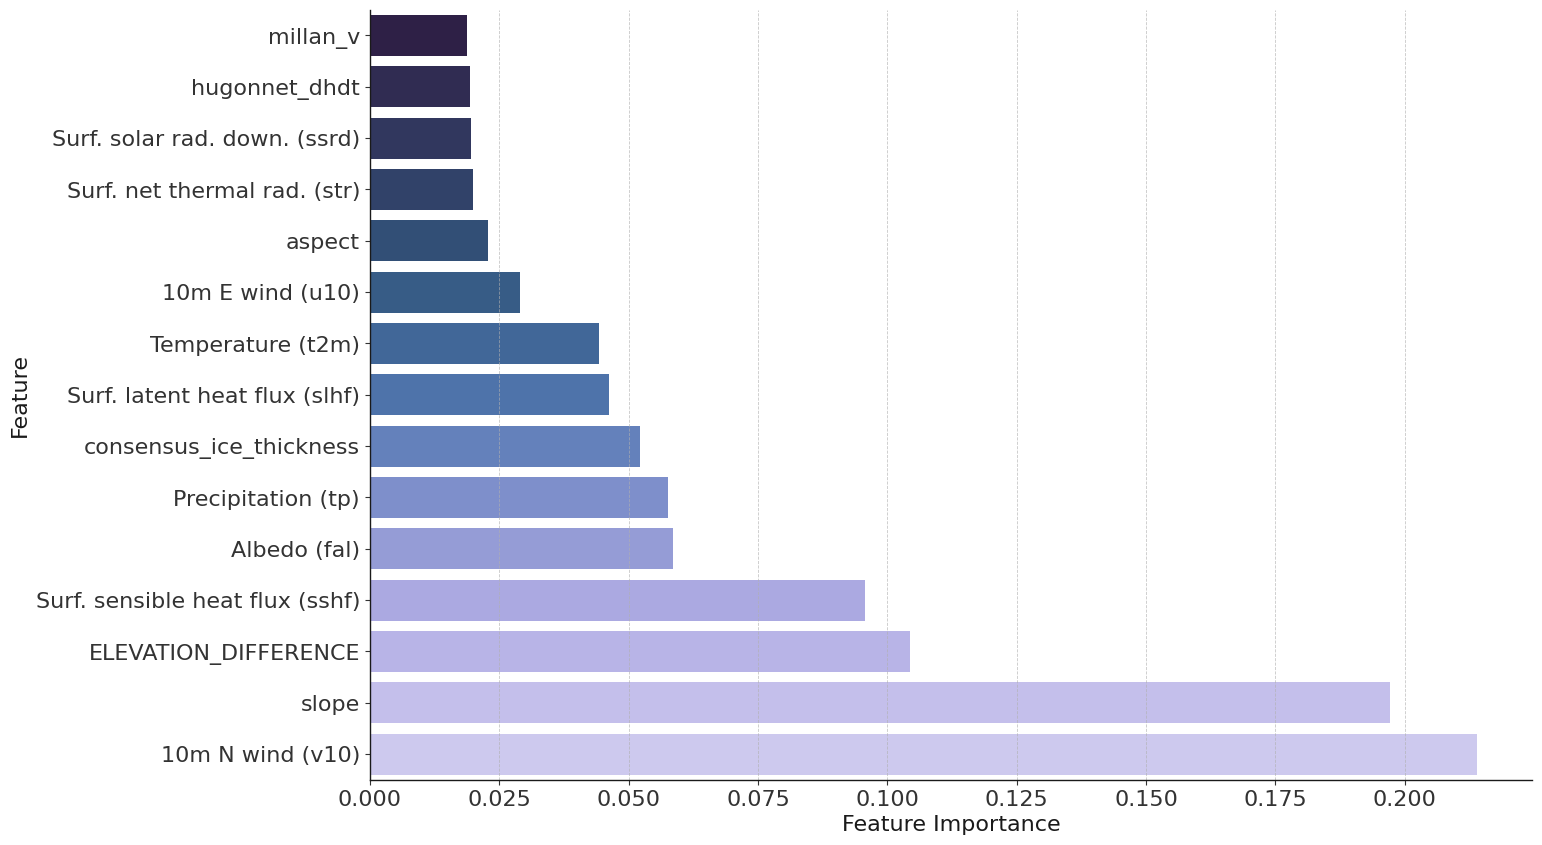

In [11]:
FIPlot(best_estimator, feature_columns, vois_climate)

Shape of the test: (78460, 15)


target  YEAR                                           POINT_ID  \
ID                                                                      
0      -0.67  2006  Argentiere_Tour_Noir_annual_smb_abl_2006_setup...   
1      -0.61  2006  Argentiere_Tour_Noir_annual_smb_abl_2006_setup...   
2      -2.94  2006  Argentiere_Tour_Noir_annual_smb_abl_2006_setup...   
3      -2.74  2006  Argentiere_Tour_Noir_annual_smb_abl_2006_setup...   
4      -0.17  2007  Argentiere_Tour_Noir_annual_smb_abl_2007_setup...   
...      ...   ...                                                ...   
7841    1.45  2022              stso_winter_smb_accu_2022_setup2022_6   
7842    1.68  2022              stso_winter_smb_accu_2022_setup2022_7   
7843    1.37  2022             stso_winter_smb_accu_2022_setup2022_10   
7844    1.22  2022             stso_winter_smb_accu_2022_setup2022_11   
7845    1.32  2022              stso_winter_smb_accu_2022_setup2022_8   

                                  GLACIER      pred  PERIOD  
ID                                                           
0                FR4N01235A08 dArgentiere -1.038056  annual  
1                FR4N01235A08 dArgentiere -1.190521  annual  
2                FR4N01235A08 dArgentiere -1.642899  annual  
3                FR4N01235A08 dArgentiere -1.879148  annual  
4                FR4N01235A08 dArgentiere -0.800509  annual  
...                                   ...       ...     ...  
7841  FR4N01162B09+154D03 de Saint Sorlin  1.261360  winter  
7842  FR4N01162B09+154D03 de Saint Sorlin  1.141014  winter  
7843  FR4N01162B09+154D03 de Saint Sorlin  1.735108  winter  
7844  FR4N01162B09+154D03 de Saint Sorlin  0.959670  winter  
7845  FR4N01162B09+154D03 de Saint Sorlin  0.853903  winter  

[7846 rows x 6 columns]

{'FR4N01235A08 dArgentiere': '#a6cee3', 'FR4N01236A02 des Grands Montets': '#1f78b4', 'FR4N01146D09+E06 Gebroulaz': '#b2df8a', 'FR4N01236A01 Mer de Glace/Geant': '#33a02c', 'FR4N01236A01 Leschaux': '#fb9a99', 'FR4N01236A07 de Talefre': '#e31a1c', 'FR4N01163A02 de Sarennes 1': '#fdbf6f', 'FR4N01162B09+154D03 de Saint Sorlin': '#ff7f00'}


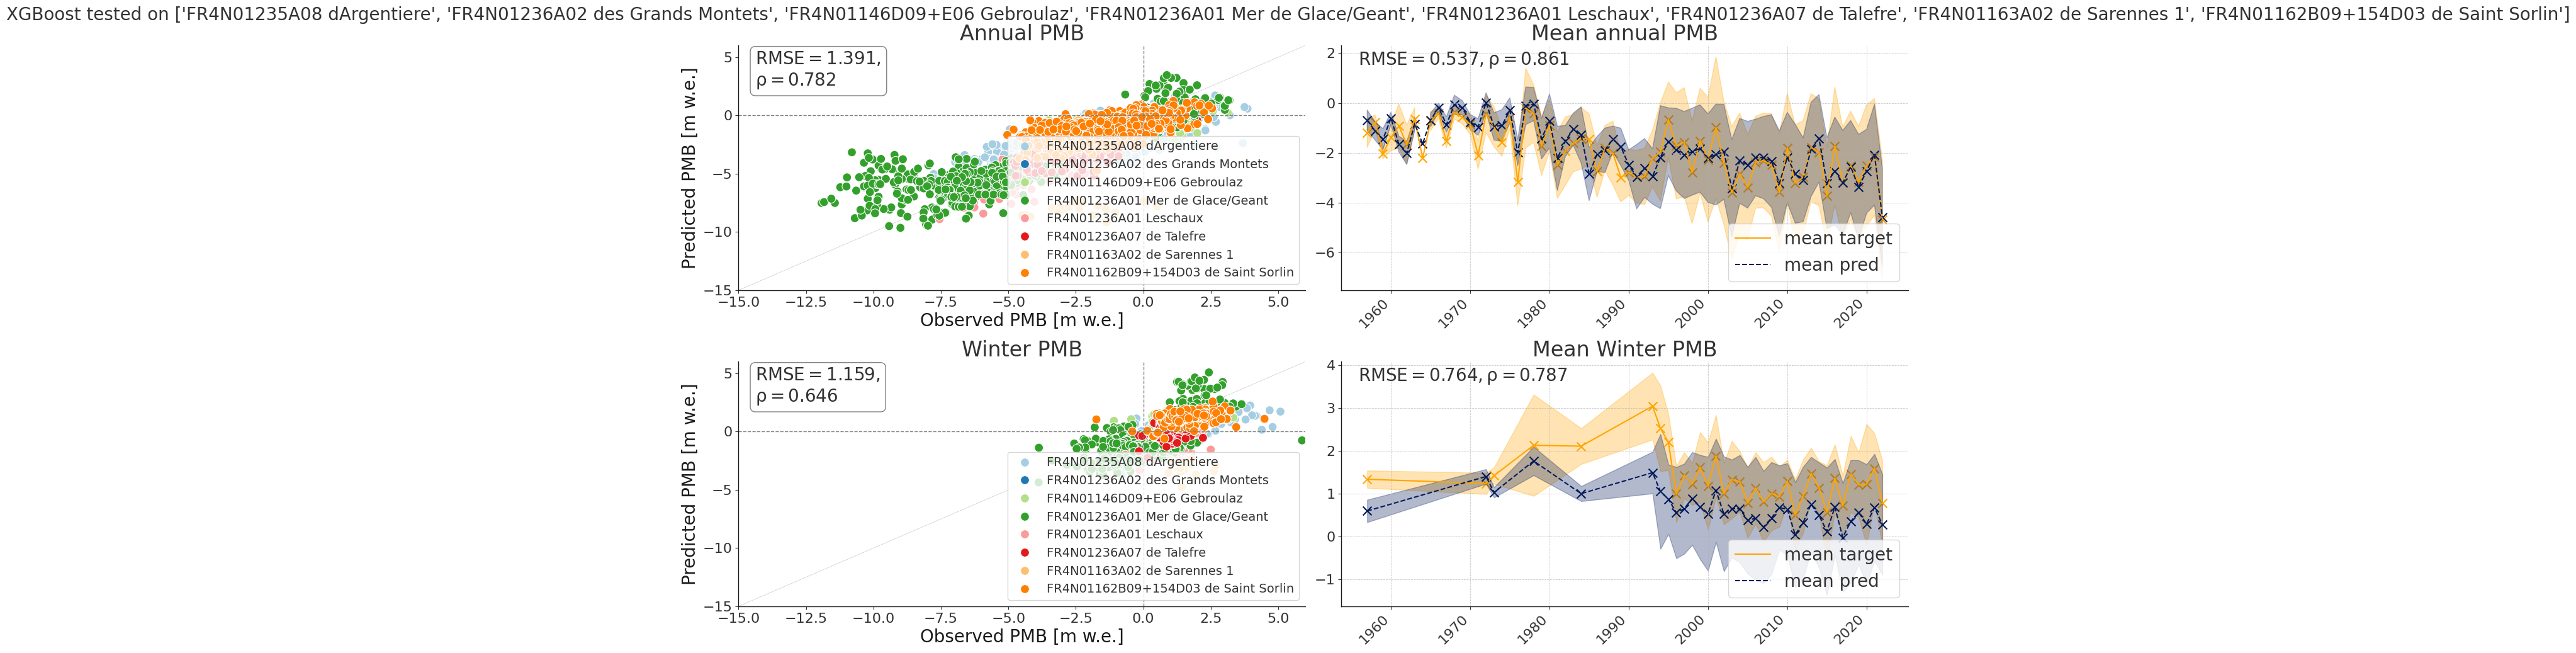

In [ ]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)


PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

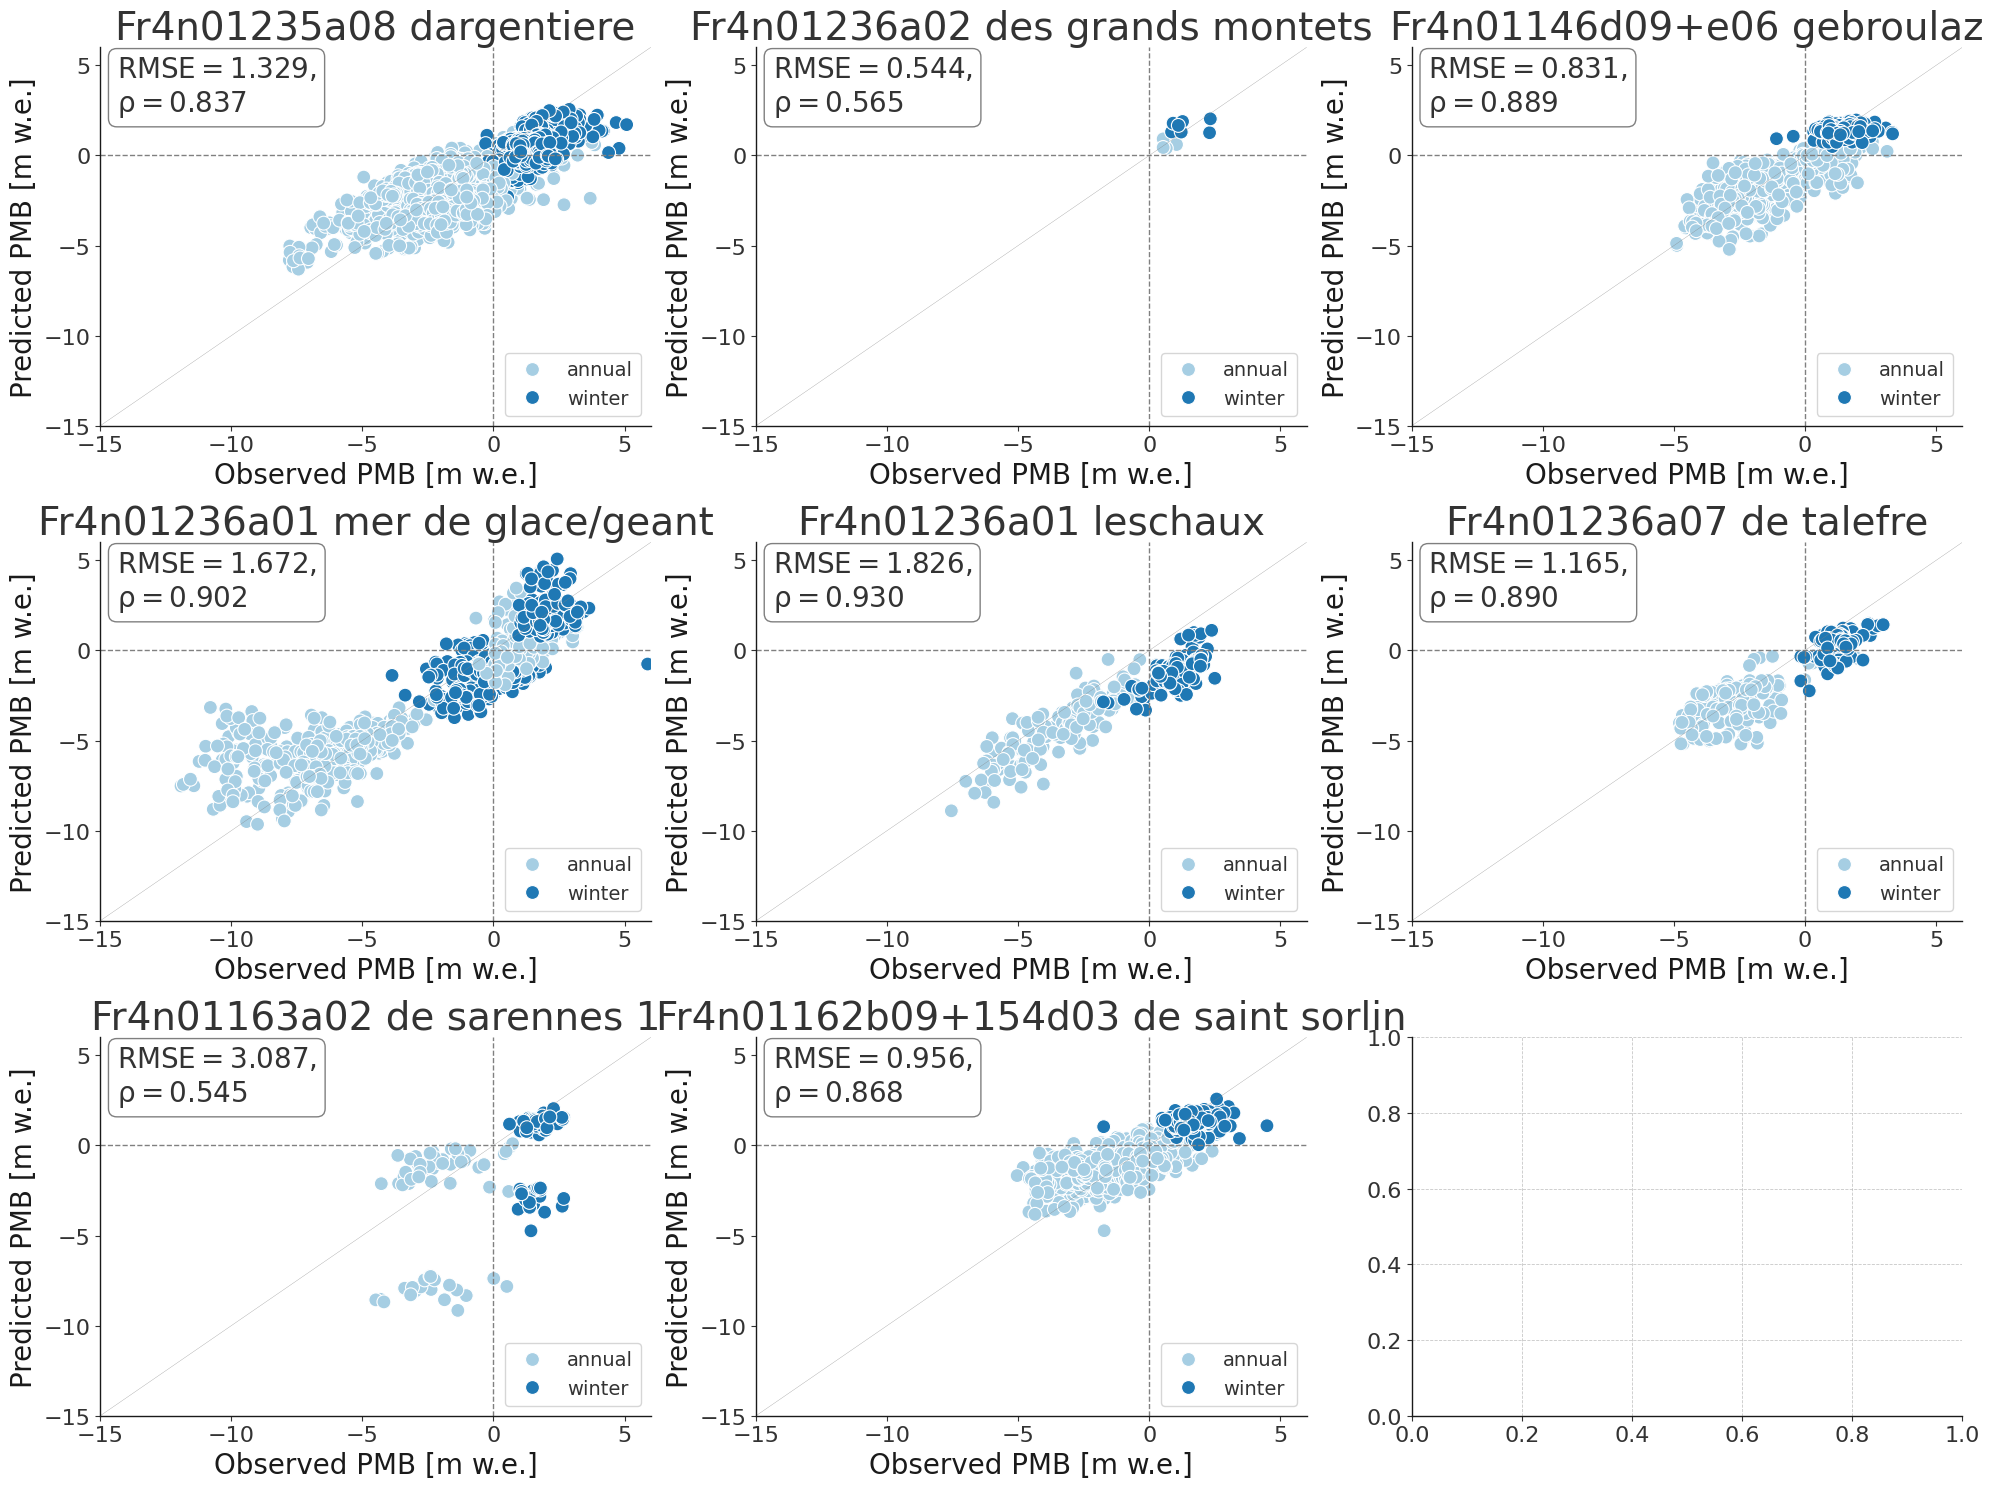

In [ ]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

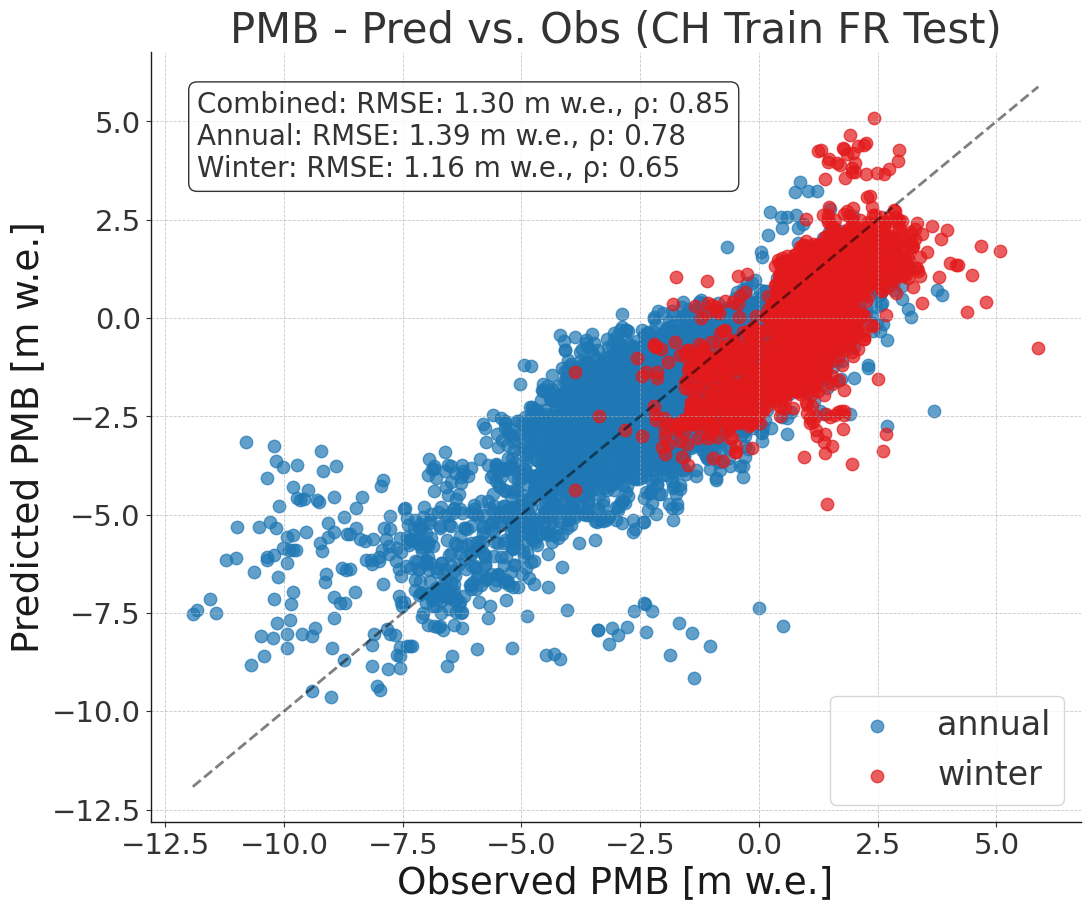

In [19]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='CH Train FR Test', include_summer = False)

### Predictions of custom parameters:

Shape of training dataset: (89125, 27)
Shape of testing dataset: (3582, 27)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v']
{'device': 'cuda:0', 'tree_method': 'hist', 'random_state': 30, 'n_jobs': -1, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}
Shape of the test: (3582, 15)
Overall score: 1.864708498483454
{'mdg': '#a6cee3'}


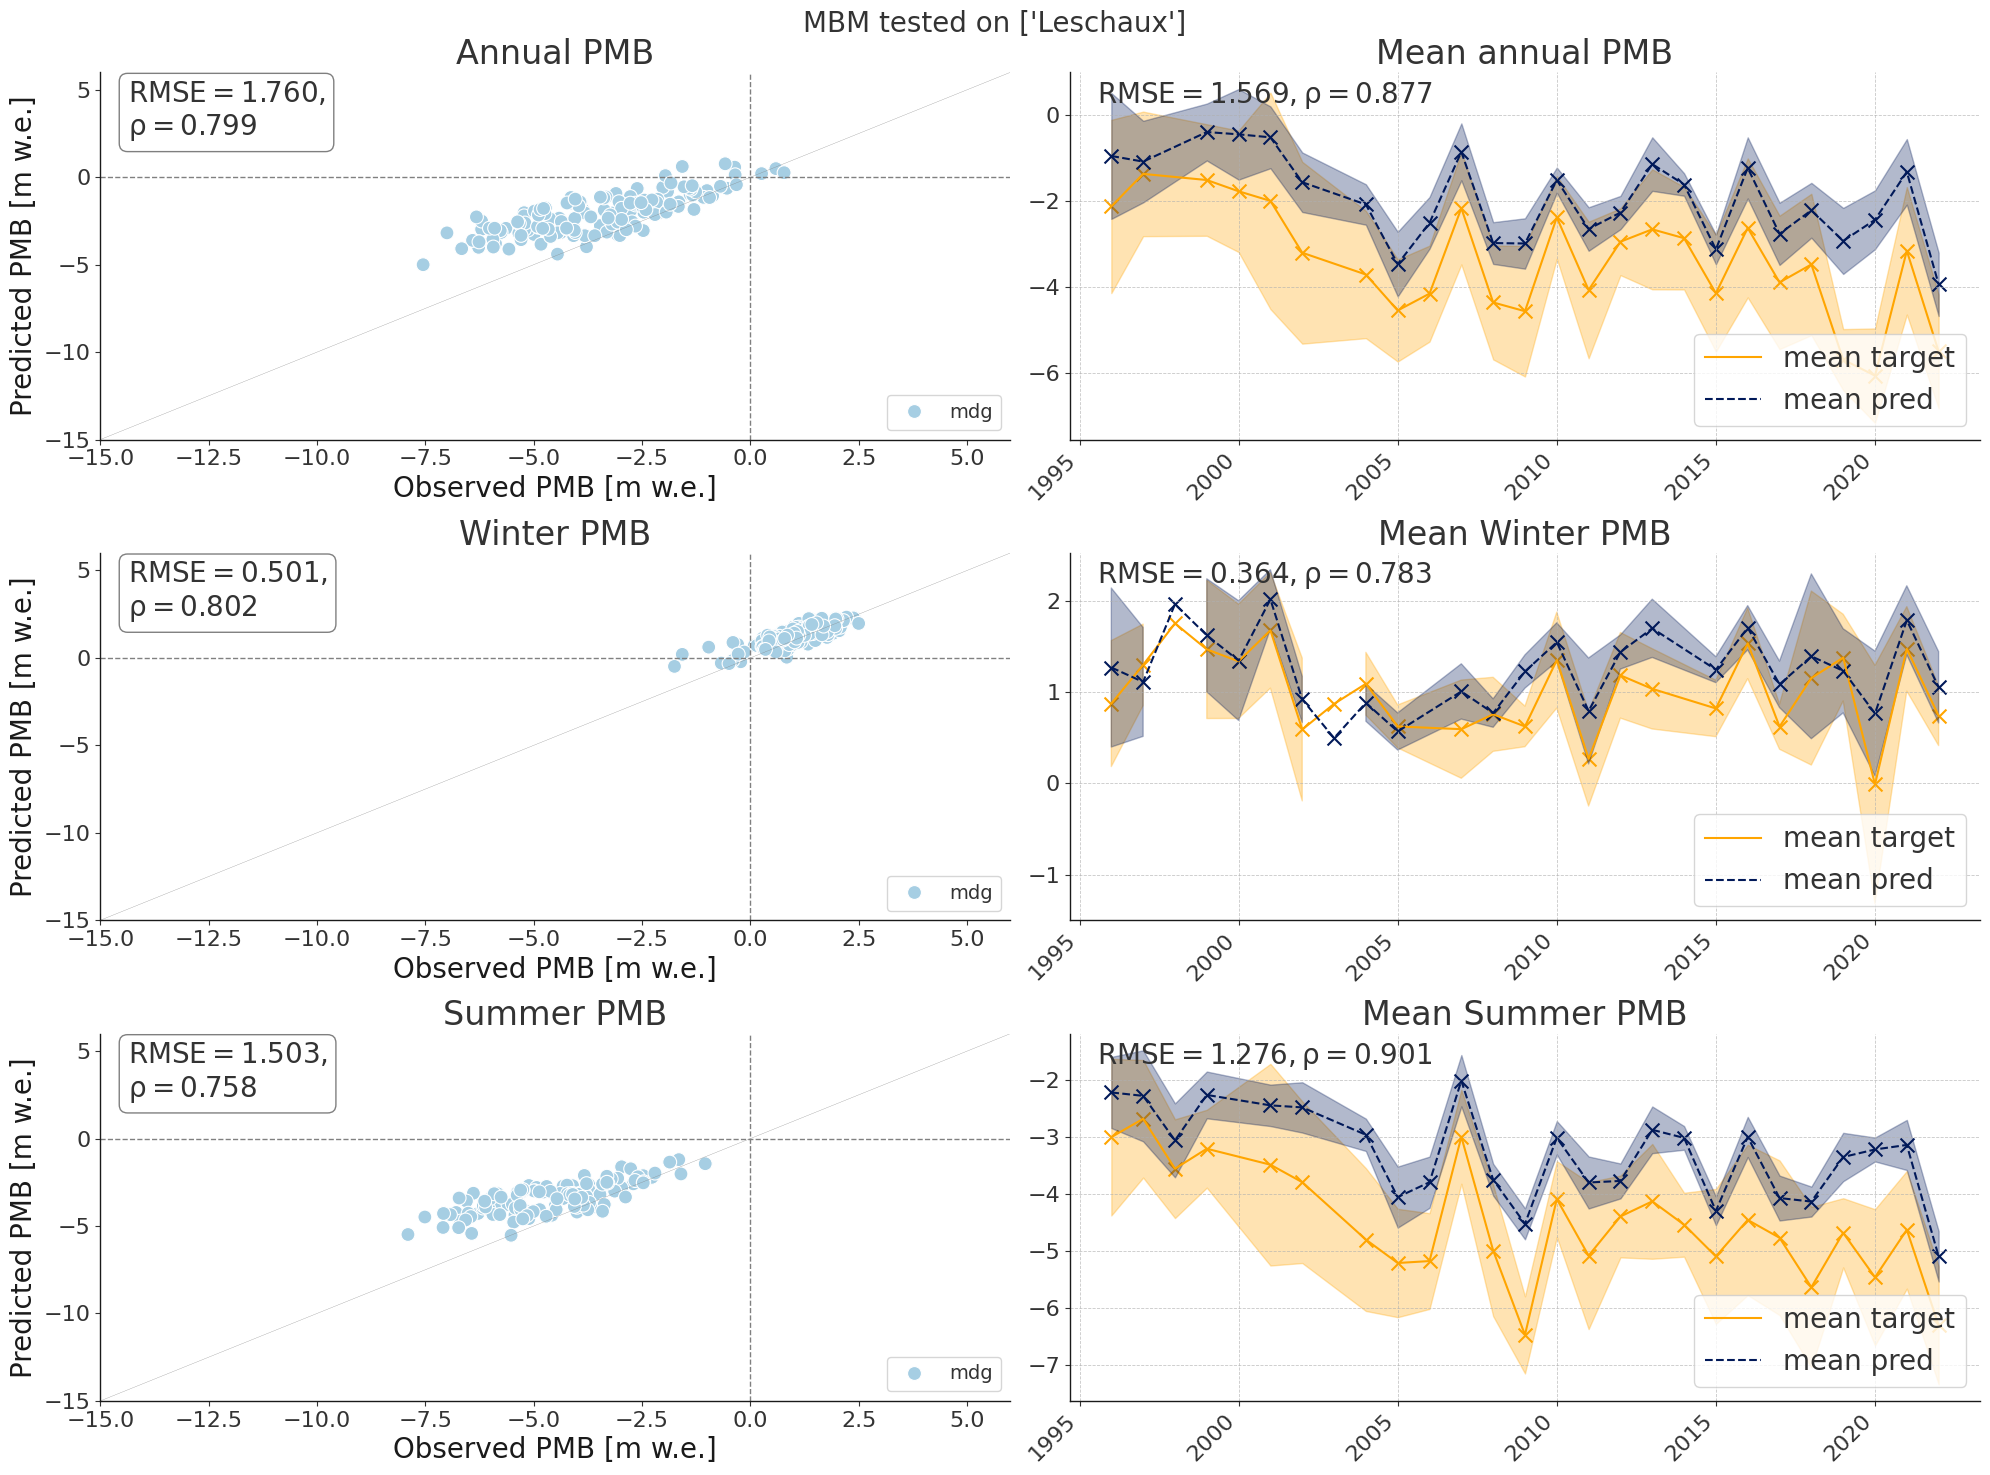

In [34]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'MBM tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

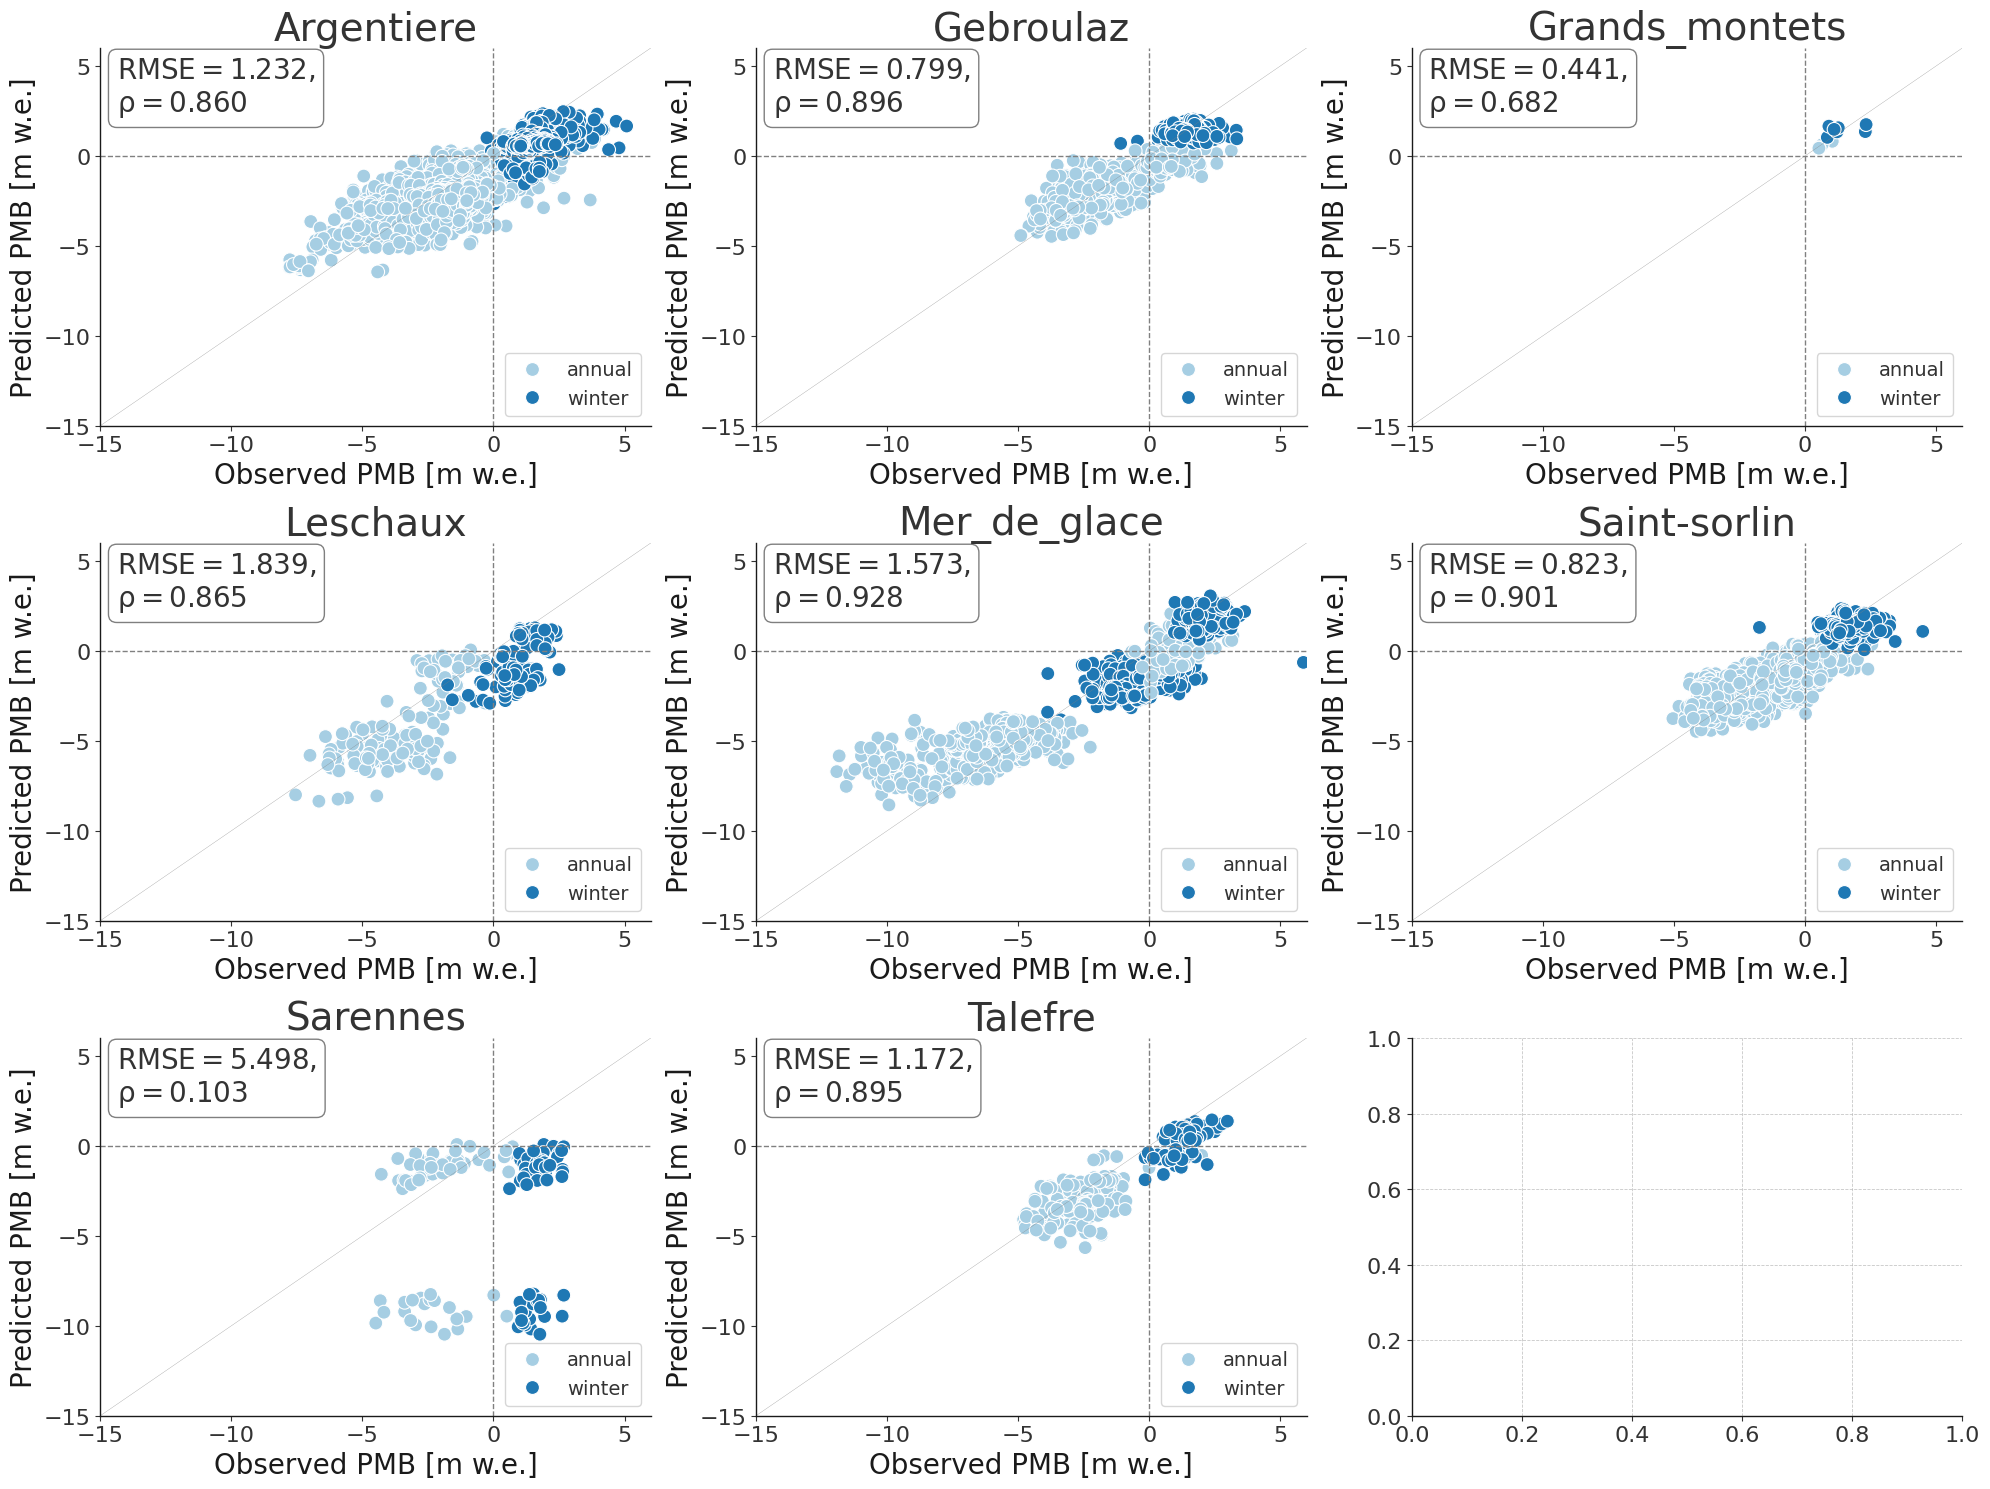

In [ ]:
# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

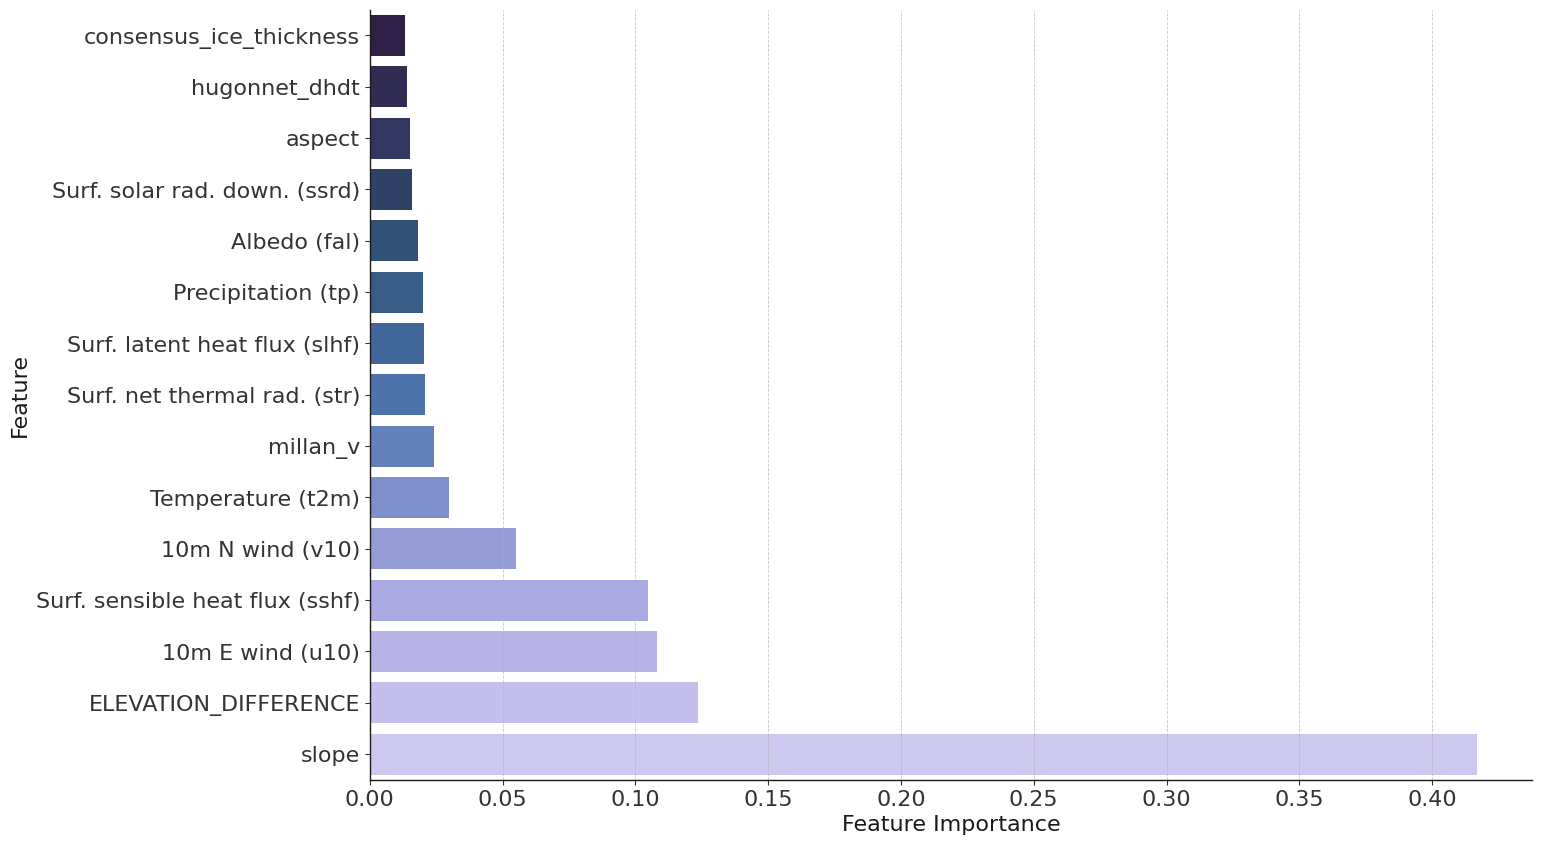

In [26]:
FIPlot(custom_model, feature_columns, vois_climate)